### Импорт необходимых библиотек

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from python_tsp.heuristics import solve_tsp_local_search, solve_tsp_simulated_annealing
import plotly.graph_objects as go
import seaborn as sns
import seaborn.objects as so
import warnings
warnings.filterwarnings("ignore")

### Получение данных и приведение их к рабочему виду путём сортировки по значениям id терминалов

In [ ]:
incomesTable = pd.read_excel('./Датасеты/terminal_data_hackathon v4.xlsx', 1)
incomesTable

In [ ]:
timeTable = pd.read_csv('./Датасеты/times v4.csv')

# Сразу учитываем 10 минут на обслуживание терминала
timeTable['Total_Time'] = timeTable.Total_Time + 10
timeTable = timeTable.sort_values(by=['Origin_tid', 'Destination_tid'])
timeTable.index = range(len(timeTable))
unT = timeTable['Origin_tid'].unique()
unT.sort()
timeTable

In [ ]:
timeTableMatrix = pd.pivot(timeTable, index='Origin_tid', columns='Destination_tid', values='Total_Time')
np.fill_diagonal(timeTableMatrix.values, 0.)
timeTableMatrix

In [ ]:
# данный словарь используется для значительного ускорения скорости поиска времени между точками

key = pd.Series((range( len(unT))))
key = key * (len(unT)-1)
dictionaryT = dict(zip(unT, key.to_list()))
#(dictionaryT)

In [ ]:
MoneyAmount = incomesTable[['TID','остаток на 31.08.2022 (входящий)']]
MoneyAmount.loc[ : ,'Дней не обслужино'] = 0
MoneyAmount.loc[ : ,'points'] = 0

In [ ]:
PATH_INCOMES = './Датасеты/terminal_data_hackathon v4.xlsx'
incs = pd.read_excel(PATH_INCOMES, sheet_name='Incomes')


incs.sort_values(by=['TID'])
incs.index = incs['TID']
incs.drop(columns='TID', inplace=True)
incs = incs.transpose()
tid_indexes = incs.columns.values

avg_inc = {i: incs[i][1:61].mean() for i in tid_indexes}
MoneyAmount['avg_income'] = MoneyAmount['TID'].map(avg_inc)
MoneyAmount

In [ ]:
# Первоначальный расчёт очков (о них сказано в описании решения задачи)
# 
# Подсчёт очков для каждого банкомата. 
# 
# Представляет собой параметр, в какой-то степени соответствующий приоритету посещения этого терминала машинами
# Максимум из "заполнонности" днями банкомата (как давно не посещался) и заполненности деньгами на момент дня
# Количество дней делим не на 14 или 13, а на 13.1 т.к. при делении на 14 алгоритм поздно реагирует на необслуженные терминалы,
# наоборот, если делить на 13, то по алгоритму они станут равноценны критически заполненным деньгами терминалам. 
# 
# Очки растут постепенно при пополненнии терминалов или их не обслуживании, и обнуляются при посещении
# Т.е. если у терминала количество очков равно 1 - он обязателен к посещению, если близко к 1 - он скорее всего посетится.

# Подсчёт ведётся нахождения максимума "загруженности" днями или деньгами

arrDays = np.array(MoneyAmount['Дней не обслужино'])
arrMon = np.array(MoneyAmount['остаток на 31.08.2022 (входящий)'])
arrInc = np.array(MoneyAmount['avg_income'])

newM = np.array([min(max((arrDays[i] / 13.1) ** 1.4, (arrMon[i]) / 1000000), 1) for i in range(len(arrInc))])

In [ ]:
MoneyAmount.loc[ : ,'points'] = newM
MoneyAmount

In [ ]:
Inc = incomesTable.loc[:, incomesTable.columns != 'остаток на 31.08.2022 (входящий)']
Inc

In [ ]:
# Загрузка данных о координатах банкоматов для построения карт

coords = pd.read_excel('./Датасеты/terminal_data_hackathon v4.xlsx', sheet_name='TIDS')
coords = coords.sort_values(by=['TID'])
coords.index = coords['TID']
coords['points'] = np.array(MoneyAmount.loc[ : ,'points'])


# Давайте оценим данные

Найдём среднюю лжидаемую посещаемость в днях, чтобы понять, сколько точек необходимо будет в среднем посещать машинам на протяжении работы алгоритма.

In [ ]:
ocenka = MoneyAmount.copy()
ocenka['Средняя ожидаемая посещаемость в днях'] = np.array(MoneyAmount['avg_income'])/1000000
ocenka.loc[ocenka['Средняя ожидаемая посещаемость в днях'] < 1/14, 'Средняя ожидаемая посещаемость в днях'] = 1/14
ocenka = ocenka.sort_values(by=['Средняя ожидаемая посещаемость в днях'])
ocenka['Средняя ожидаемая посещаемость в днях'].sum()

Нами были проведены тесты алгоритма поиска путей, где мы искали лишь пути по ближайшим точкам. Такой метод позволил достичь количества точек около 55 для областей высокой концентрации терминалов и количества точек около 30 для зон низкой концентрации. 
3 машины будут иметь в идеальном случае 150 - 160 точек в маршруте, чего, кажется, должно хватать. Однако на практике точки заполняются совсем неоднородно, пути приходится строить по всей карте москвы и мы считаем что для 3-х машин с заданными условиями (посещение хотя бы раз в 14 дней и посещение при накоплении миллиона) неразрешима. 
А так как, по нашему анализу, основные расходы связаны именно с содержанием машин, уменьшение количество автомобилей в парке стоит в приоритете.

Поэтому перед нами стояла задача решения задачи для 4-х машин, с чем мы и справились. Оптимизация по остальным статьям расходов также учитывалась. 

# Описание решения задачи

Наше решение можно разбить на несколько частей.

Самая важная часть нашего решения - создание критерия приоритетности посещения терминалов, столбец "points" матрицы MoneyAmount (также содержится в матрице coords для построения графиков).
Данная оценка позволяет следующей части нашего алгоритма - функции построения маршрутов, стабильно решать задачу выполнения условий для каждого дня, при этом упрощая решения для последующих дней.

Благодаря нашей системе оценки карта терминалов делится на зоны плотности, созданные путями маршрутов, что помогает их построению в будущем. 

В этой системе учитывается заполненность терминала деньгами и время его последнего посещения, а также, для тренировочных данных найденное среднее поступление денег в банкомат, а для тестовых - спрогнозированные данные n-beats модели на 30 дней, полученные обучением на первых 60 днях. Данные были выгружены программой "Forecast_time_series_model.ipynb" в файл "forecast_last_30_days_data.xlsx" и загружены в этом файле перед основной функцией. Использование спрогнозированных данных позволяет уточнять оценки, а значит стабилизировать весь алгоритм.

Система очень гибкая, параметров много, и все можно настраивать, поэтому она может быть применима и в других задачах логистики.

Настройка параметров, которые установлены в ней сейчас, велась посредством тестов и сравнения целевых показателей (расходов, срыва условий). В результате мы добились соблюдения условий для 4-х машин по тестовому месяцу, и общих затрат по нему около 3.530.000 рублей. 

Стоит заметить, что после построения путей происходит их оптимизация по времени алгоритмом perturbation algorithm по схемам two optimum либо ps6 (настраивается в ручную). Данные схемы используют стохастические методы, а значит результаты могут незначительно отличаться. Из этого следует, что маршруты могут строить по разному на долгих промежутках времени. Однако, стоит заметить, система стабильна - при каждом запуске нарушений условий не было.

В комментариях далее описан принцип работы каждой из функций.

### Секция основной программы

In [ ]:
# Функция, выводящая самый приоритетный терминал из списка (список поступает уже без посещённых точек)

def TopT(MoneyT: pd.DataFrame):

    """Функция, выводящая самый приоритетный терминал из списка (список поступает уже без посещённых точек)"""

    top = MoneyT.sort_values(by=['points']).tail(1).iloc[:,0]
    
    return top.values

In [ ]:
# Функция нахождения "ближайшей" точки
# Критерий: (КоличествоОчков ^ СтепеньОчков) / ВремяДоТочки (10 минут на обслуживание добавлены после загрузки файла)
# 
# Благодаря такому поиску маршруты получаются насыщеными точками с высоким приоритетом посещения,
# а также, если посмотреть на карту, по маршруту в дальнейшем образуются скопления точек с похожим количеством очков,
# что делает их посещение удобнее для алгоритма в будущем
# Путём прогона нашего алгоритма с различными параметрами были подобраны оптимальные их значения

def findNearestMdivTime(t: int, TimeT: pd.DataFrame, MoneyT: pd.DataFrame, visited = [], pointsDegr = 1.3):

    """Функция нахождения "ближайшей" точки. Критерий: (КоличествоОчков ^ СтепеньОчков) / РасстояниеДоТочки"""
    
    newT = TimeT
    newM = MoneyT[~MoneyT['TID'].isin(visited)]

    # В тестировании использовалась для сопоставления матриц (проверка корректности данных)
    # Сейчас в этом скорее нет необходимости
    listsAreEqual = newT['Destination_tid'].to_list() == newM['TID'].to_list()

    if listsAreEqual:
        # Находим полезный терминал
        npT = np.array(newT['Total_Time'].to_list(), float)
        npM = np.array(newM['points'].to_list(), float)
        maxInd = np.argmax(npM**pointsDegr/npT)
        return [int(newM.iloc[maxInd,:]['TID']), max(npM**pointsDegr/npT)]
    else:
        display('findNearestMdivTime EROR, lists are not equal', t, ', vis = ', visited , ', Исходные матрицы ')
        display(TimeT)
        display(MoneyT)
        display('Полученные матрицы')
        display(newT)
        display(newM)

In [ ]:
# Вспомогательная функция нахождения денег в терминале

def moneyInID(id: int, MoneyT: pd.DataFrame):

    """Вспомогательная функция нахождения денег в терминале"""

    return int(MoneyT[MoneyT['TID'] == id]['остаток на 31.08.2022 (входящий)'].iloc[0])

In [ ]:
# Вспомогательная функция нахождения времени от точки А к точке Б

def timeInID(origId: int, destId: int, TimeT: pd.DataFrame, dictionaryT):
    
    """Вспомогательная функция нахождения времени от точки А к точке Б"""
    
    return float(TimeT.iloc[dictionaryT[origId] + int(dictionaryT[destId]/(len(dictionaryT)-1)) - int(destId > origId)]['Total_Time'])
    

In [ ]:
# Вспомогательная функция нахождения времени пути
# мы пренебрегаем разницей прохождения пути в одну или в другую стороны, т.к. это не показало своей значимости в тесте

def findPathTime(path: list, dictionaryT = dictionaryT, TimeT = timeTable):
    
    """Вспомогательная функция нахождения времени пути"""
    
    sumTime = 10
    for i in range(len(path)-1):
        sumTime += timeInID(path[i], path[i+1], TimeT, dictionaryT)
        
    return sumTime

In [297]:
# Функция оптимизации маршрута. Получает на вход список точек маршрута (по порядку объезда) и матрицу путей, созданную ранее
# возвращает найденный не худший маршрут
# Данная функция занимает основное время алгоритма (более 90%)
# На более производительных компьютерах её можно дополнить новыми методами,
# но и в текущем состоянии она справляется со своей задачей и стабилизирует систему

def pathOprimazer(path, timeTableMatrix = timeTableMatrix):

    """Функция оптимизации маршрута. Получает на вход список точек маршрута (по порядку объезда) и 
    матрицу путей, созданную ранее возвращает найденный не худший маршрут"""

    # получаем матрицу только для точек из маршрута
    distance_matrix = timeTableMatrix.loc[path, path]
    distance_matrix.columns = range(len(distance_matrix))
    distance_matrix.index = range(len(distance_matrix))

    # предыдущий маршрут
    prev = list(range(len(distance_matrix)))

    # т.к. возвращаться не нужно, приравниваем столбец точки отправления к 10
    distance_matrix.iloc[:,0] = 10

    # находим новый оптимизированный путь и его время.

    #permutation, distance = solve_tsp_local_search(np.array(distance_matrix), x0 = prev, perturbation_scheme="ps6", max_processing_time=None)
    
    permutation, distance = solve_tsp_local_search(np.array(distance_matrix), x0 = prev, perturbation_scheme="ps6", max_processing_time=None)

   

    # сопоставляем id и новый путь, и возвращаем его
    a = [(i, j) for i, j in enumerate(permutation)]
    newP = np.array([(path[a[i][1]]) for i in range(len(a))])

    return newP.tolist(), distance

In [298]:
# Функция приведения путей к заданному условиями времени. Удаляет наименее приоритетные точки
# Считает как сильно сэкономит удаление точки времени, и как много очков она имеет

def pathToRightTime(path : list, MoneyT: pd.DataFrame, TimeT = timeTable, dictionaryT = dictionaryT):
    
    """Функция приведения путей к заданному условиями времени. Удаляет наименее приоритетные точки. 
    Считает как сильно сэкономит удаление точки времени, и как много очков она имеет"""

    # объявление необходимых переменных
    PathToD = path.copy()
    pTime = findPathTime(PathToD, dictionaryT, TimeT)

    # основной цикл
    while pTime > 720:
        timeList = []

        # для каждой точки находим выгоду от её удаления
        for i in range(len(PathToD)):
            p2Change = PathToD.copy()

            # рассматриваем удаление точки из маршрута 
            p2Change.pop(i)

            # находим сэкономленное время
            timeDiff = pTime - findPathTime(p2Change, dictionaryT, TimeT)

            # находим очки точки
            points = MoneyT.loc[MoneyT['TID'] == PathToD[i], 'points'].iloc[0]

            # и вычисляем критерий выгоды удаления (точки с количеством очков = 1 не удаляются)
            if float(points) != 1.0:
                timeList.append(points**3/timeDiff)
            else:
                timeList.append(100)

        # удаляем точку (не всегда оптимальную, для нахождения оптимума нужен перебор всех комбинаций удаляемых точек, что долго)
        PathToD.pop(np.argmin(timeList))
        pTime = findPathTime(PathToD, dictionaryT, TimeT)

    return PathToD, pTime

In [ ]:
# Функция поиска пути. Работает по принципу жадного алгоритма, с некоторыми изменениями
# 
# На вход поступает исходная точка, таблица времени и очков, а также список уже посещённых вершин и степень очков 
# для удобства также передаётся созданный ранее словарь для быстрого поиска времени между точками (сильно сокращает время поиска)
# 
# Для изначальной точки находится пара (функция findNearestMdivTime, описана ранее)
# Далее эти две точки рассматриваются как концы пути, и идёт последовательный поиск в обе стороны
# Как только время пути превысит 720 мин, мы оптимизируем его (функция pathOprimazer, описана ранее), и,
# если время всё ещё превышает допустимое, путь сокращается (функция pathToRightTime, описана ранее)

def grPath(t: int, TimeT: pd.DataFrame, MoneyT: pd.DataFrame, visited: list, dictionaryT = dictionaryT, pointsDegr = 1.3):
    
    """Функция поиска пути. Работает по принципу жадного алгоритма, с некоторыми изменениями. 
    На вход поступает исходная точка, таблица времени и очков, а также список уже посещённых вершин и степень очков 
    для удобства также передаётся созданный ранее словарь для быстрого поиска времени между точками"""


    # Определение необходимых переменных 
    pathTime = 10
    vis =  visited.copy()      # здесь мы храним посещённые точки
    path = []                  # а здесь полученный маршрут 
    path.append(t)
    vis.append(t)


    pathMoney = moneyInID(t, MoneyT)     # эта переменная будет хранить сумму маршрута 
    helperT = TimeT.iloc[dictionaryT[t]:dictionaryT[t]+len(dictionaryT)-1]

    # концы маршрута мы называем firstT и secondT
    firstT = t
    # определяем вторую точку и обновляем данные
    secondT = findNearestMdivTime(firstT, helperT[~helperT['Destination_tid'].isin(vis)], MoneyT, vis, pointsDegr)[0]
    path.append(secondT)
    vis.append(secondT)
    pathTime += timeInID(firstT, secondT, TimeT, dictionaryT)
    pathMoney += moneyInID(secondT, MoneyT)

    # объявляем вспомогательные переменные для сравнения новых точек ()
    NewSecondT = NewFirstT = coefNewSecond = coefNewFirst = -1.

    # запускаем основной цикл
    # Мы используем такой цикл т.к. он более гибок, и мы можем вести поиск маршрутов разной
    # длинны. Как только время пути становится больше, мы удаляем малоприоритетные точки.
    # Это позволяет находить более дальёкие приоритетные точки, либо делать маршрут более насыщенным но коротким.
    while pathTime < 720:
        
        # можно проводить оптимизацию путей несколько раз, но это не показало себя эффективным
        #if len(path) % 10:
        #    path, RealPathT = pathOprimazer(path, timeTableMatrix)
        #    NewSecondT = path[-1]

        # Ищем потенциальные новые вершины
        helperT = TimeT.iloc[dictionaryT[firstT]:dictionaryT[firstT]+len(dictionaryT)-1]     # таблица времени только от нужной точки до остальных, чтобы не передавать 2 млн строк
        NewFirstT, coefNewFirst = findNearestMdivTime(firstT, helperT[~helperT['Destination_tid'].isin(vis)], MoneyT, vis, pointsDegr)

        helperT = TimeT.iloc[dictionaryT[secondT]:dictionaryT[secondT]+len(dictionaryT)-1]   # таблица времени только от нужной точки до остальных, чтобы не передавать 2 млн строк
        NewSecondT, coefNewSecond = findNearestMdivTime(secondT, helperT[~helperT['Destination_tid'].isin(vis)], MoneyT, vis, pointsDegr)

        # сравниваем, какая из них выгоднее и добавляем в соответвтующий конец маршрута
        if coefNewSecond > coefNewFirst:
            path.append(NewSecondT)
            vis.append(NewSecondT)
            pathTime += timeInID(secondT, NewSecondT, TimeT, dictionaryT)
            pathMoney += moneyInID(NewSecondT, MoneyT)
            secondT = NewSecondT
        else:
            path.insert(0, NewFirstT)
            vis.append(NewFirstT)
            pathTime += timeInID(firstT, NewFirstT, TimeT, dictionaryT)
            pathMoney += moneyInID(NewFirstT, MoneyT)
            firstT = NewFirstT


    # оптимизируем машрут (находим локальный опмимум)
    path, RealPathT = pathOprimazer(path, timeTableMatrix)

    # если время окажется больше 720 мин, удалим лишние точки. Также может использоваться для удаления низкоприоритетных точек
    path, RealPathT = pathToRightTime(path, MoneyAmount)

    # Возвращаем путь словарём (для удобства)
    return {'path': path, 'pathMoney': pathMoney, 'pathTime': RealPathT}



In [ ]:
# Функция оболочка (для удобства) функции нахождения одного пути

# Получает матрицу очков и список посещённых другими машинами терминалов,
# запускает функцию поиска самого приоритетного объекта
# Передаёт точку в функцию поиска маршрутов

def findPathGreedy(MoneyT: pd.DataFrame, dictionaryT,  carPaths = [], TimeT = timeTable, pointsDegr = 1.3):
    
    """Функция оболочка (для удобства) функции нахождения одного пути.
    Получает матрицу очков и список посещённых другими машинами терминалов,
    запускает функцию поиска самого приоритетного объекта.
    Передаёт точку в функцию поиска маршрутов"""

    # находим самый приоритетный терминал (его id)
    t = TopT(MoneyT[~MoneyT['TID'].isin(carPaths)])
    
    # Находим путь, используя этот терминал как исходную точку (он не обязательно окажется началом или концом т.к. поиск идёт в две стороны)
    newP = grPath(t[0], TimeT, MoneyT, carPaths, dictionaryT, pointsDegr)
    print('path len = ', len(newP["path"]))
    print("pathMoney = ",newP["pathMoney"], ", pathTime =",newP["pathTime"])

    return newP

In [283]:
# Функция поиска путей для заданного количества машин

def allCarsFindPathGreedy(MoneyT: pd.DataFrame, dictionaryT, cars = 4, TimeT = timeTable, pointsDegr = 1.3):

    """Функция поиска путей для заданного количества машин."""
    
    # Ведём учёт всех путей
    carPaths = []
    carDots = []

    # Цикл для всех машин
    for i in range(cars):
        #print(i)
        
        # По сути, каждый раз запускается функция нахождения пути для 1 машины, только с разными параметрами,
        # в зависимости от нагруженности. Для первых (3-х в данном случае) машин степень очков не изменяется, для 
        # остальных/последней (количество настраеваемо) - можно повысить степень очков (их важность), при наблюдении
        # повышенной нагрузки. Помогает стабилизировать систему.

        if (i != cars - 1):
            newCarPath = findPathGreedy(MoneyT, dictionaryT, carDots.copy(), TimeT, pointsDegr)
            #optimazer
            carPaths.append(newCarPath)
            carDots += newCarPath['path']


        if (i >= cars - 1):

            # Анализ нагрузки на алгоритм (количества обязательных к посещению сегодня автомобилей)
            helperMT = MoneyT['TID'].isin(carDots)
            MatrCheck = MoneyT.loc[~helperMT, 'points']

            if len(MatrCheck.loc[MatrCheck == 1]) > cars - i:
                print('Сегодня загруженный день!')
                newCarPath = findPathGreedy(MoneyT, dictionaryT, carDots.copy(), TimeT, pointsDegr*5)
                carPaths.append(newCarPath)
                carDots += newCarPath['path']
            else:
                newCarPath = findPathGreedy(MoneyT, dictionaryT, carDots.copy(), TimeT, pointsDegr)
                carPaths.append(newCarPath)
                carDots += newCarPath['path']

    return carPaths

In [284]:
# Тестовый запуск функции нахождения путей для первого дня, число 4 отвечает за количество машин, 1.3 - за степень очков (используется в оценке при построении)
pathsTest = allCarsFindPathGreedy(MoneyAmount, dictionaryT, 4, timeTable, 1.3)

path len =  44
pathMoney =  40916000 , pathTime = 688.2800000000001
path len =  43
pathMoney =  25981000 , pathTime = 711.2400000000001
path len =  41
pathMoney =  21563000 , pathTime = 716.1000000000001
path len =  39
pathMoney =  21126000 , pathTime = 705.4500000000002


In [ ]:
# Использовался для тестов путей на пересечения, пути не пересекаются т.к. при построении пути предыдущих машин учитываются для каждого дня
# Как можно заметить, все пути встречаются по разу

testList = []
print(len(pathsTest))
for p in pathsTest:
    testList += p['path']
print(testList)
print(Counter(testList))

In [ ]:
# Функция нахождения потерь

def findLoss(MoneyT: pd.DataFrame,  carN: int, TermServLoss: float) -> list:

    """Функция нахождения потерь."""

    sum = 0.

    #1. Величина % в годовых, которую банк платит за неинкассированную сумму денег в терминале - 2 (т.е. сумма за день = остаток * 2/100/365);
    nonCashedLoss = (MoneyT['остаток на 31.08.2022 (входящий)'].sum())*2/100/365
    sum += nonCashedLoss

    #2. Стоимость обслуживания одного терминала в случае его инкассирования = 0,01% от суммы инкассации, но не менее 100 рублей (т.е. для суммы 50000 = 100, для суммы 1500000 = 150);
    servicesLoss = TermServLoss #
    sum += servicesLoss
    
    #3. Стоимость одного броневика на день - 20000;
    carLoss = 20000*carN
    sum += carLoss
    
    return [sum, nonCashedLoss, servicesLoss, carLoss]

In [ ]:
# Функция нахождения стоимости обслуживания
# Принимает остатки на обслуживаемом терминале, возвращает стоимость обслуживания 

def moreThenMillionFindMaksim(l):
    
    """Функция нахождения стоимости обслуживания."""

    sumServ = 0.
    for i in l:
        a = i * (0.01 / 100) if i * (0.01 / 100) > 100 else 100.
        sumServ += a
    return sumServ


In [ ]:
def moreThenMillionFindOTCHET(l):
    
    """Служебная функция для отчёта"""

    sumServ = []
    for i in l:
        a = i * (0.01 / 100) if i * (0.01 / 100) > 100 else 100.
        sumServ.append(a)
    return sumServ


In [362]:
# Функция подсчёта очков для каждого банкомата. Самая важная часть нашего решения.
# Данная функция помогает алгоритму уделять больше внимания грядущим дням, а не только решать задачу дня текущего.

# Представляет собой параметр, в какой-то степени соответствующий приоритету посещения этого терминала машинами
# Максимум из "заполнонности" днями банкомата (как давно не посещался) и заполненности деньгами на момент дня
# Количество дней делим не на 14 или 13, а на 13.1 т.к. при делении на 14 алгоритм поздно реагирует на необслуженные терминалы,
# наоборот, если делить на 13, то по алгоритму они станут равноценны критически заполненным деньгами терминалам.
# Очки растут постепенно при пополненнии терминалов или их не обслуживании, и обнуляются при посещении
# Т.е. если у терминала количество очков равно 1 - он обязателен к посещению, если близко к 1 - он скорее всего посетится.

# Подсчёт ведётся нахождения максимума "загруженности" днями или деньгами (учитывая прогноз или среднее поступление)
# А после мы берём минимум из полученного значения и единицы. Т.е. единима это максимальное количество очков.

# Я хотел бы написать небольшой пример, поясняющий данную функцию Если она вам понятно, можете пропустить.
# 
# Начнём с загруженности днями. Допустим банкомат не обслуживался 13 дней. Его очки будут равны (13 / 13.1) ** 1.4
# или 0.989329. Данное количество очков не будет перетягивать много внимания алгоритма от возможных "единиц" - заполненных терминалов.
# При этом оно делает терминал высокоприоритетным. 
# 
# Теперь рассмотрим оценку заполненности деньгами. Если терминал заполнен на 500т., то одна из оценок будет мин(0.5, 1) (на самом деле чуть сложнее, учитывается заполненность терминала)
# Далее рассматриваем среднее поступление в терминал, расчитанное на тренировочных данных. Допустим 700 т.
# Мы выбираем минимум между этим средним поступлением и деньгами в терминале (чтобы не обслуживать пустые терминалы с большим ожидаемым пополнением)
# И складываем этот минимум с имеющимися деньгами. В нашем случае 500т + мин(700т, 500т) = 500т + 500т = 1000т, и конечно делим на миллион.
# Но т.к. это прогноз, чтобы не отвлекать внимание алгоритма мы выбираем между этим прогнозом (число от 0 до 1) и 0.94,
# таким образом, повышая его проиорит. И дальше мы находим максимум между прогнозом (0 - 0.94) и реально заполненностью (0 - 1).
# 
# И дальше мы сравнимаем полученные очки для денег и времени, выбираем максимум из них. И минимум из полученного числа и единицы. Вот так просто.
# 
# Данная функция помогает алгоритму уделять больше внимания грядущим дням, а не только решать задачу дня текущего.

def updatePoints(MoneyT):

    """Функция подсчёта очков для каждого банкомата."""

    arrDays = np.array(MoneyT['Дней не обслужино'])
    arrMon = np.array(MoneyT['остаток на 31.08.2022 (входящий)'])
    arrAvg = np.array(MoneyT['avg_income'])

    newM = np.array([min(max((arrDays[i] / 13.1) ** 1.4, max(min((arrMon[i] + arrAvg[i] * (arrMon[i] / 1000000) ** 3) / 1000000, 0.85), arrMon[i] / 1000000)), 1) for i in range(len(arrInc))])

    #0.9 / max((1 + np.exp(-1 / 50000 * (arrMon[i] - 500000))) + arrMon[i] ** 1.05 / 10000000), arrMon[i] / 1000000)

    return newM


In [363]:
# Используется для формирования отчёта

import datetime as DT
time_interval = pd.date_range(start='9/1/2022', end='11/30/2022') + pd.Timedelta(hours=8)

In [364]:
# Загружаем данные, сгенерированные в файле Forecast_time_series_model.ipynb на основе тренировочных данных. 
# Представляют из себя предсказания поступлений для каждого из терминалов (в файле логарифм предсказаний).

forecastT = pd.read_excel('./forecast_last_30_days_data.xlsx')
forecastT = forecastT.transpose()
forecastT.columns = forecastT.iloc[0]
forecastT.drop(forecastT.index[0], inplace=True)
forecastT = forecastT.apply(pd.to_numeric)
forecastT = np.exp(forecastT)
forecastT



Unnamed: 0,2022-11-01 00:00:00,2022-11-02 00:00:00,2022-11-03 00:00:00,2022-11-04 00:00:00,2022-11-05 00:00:00,2022-11-06 00:00:00,2022-11-07 00:00:00,2022-11-08 00:00:00,2022-11-09 00:00:00,2022-11-10 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
406136,68437.783649,64534.791144,76424.063051,101021.962590,123751.798141,124089.911301,104022.196267,84230.182143,77245.619172,85049.958520,...,93065.437978,79842.352198,74633.484805,80371.621594,94667.232644,108490.672375,110099.987680,98358.394802,83562.663372,74126.731420
406139,192273.595634,193487.261471,193192.064232,177541.192522,151788.371732,132441.926284,129684.710621,144002.698565,165129.195883,171606.680480,...,132849.511590,139482.782443,142068.443454,128299.925372,103528.051622,84469.175528,81745.971012,100658.637241,143187.615938,187292.103591
406145,75593.508089,80755.932554,100142.644255,118753.580148,118930.952234,104924.371892,95933.430504,104363.916466,133899.763256,173264.296464,...,91453.409706,93928.107790,114164.999764,138402.466367,142209.284239,121024.319944,98047.371564,91976.894600,110235.310169,155129.849533
406148,9538.383082,9110.038231,9184.274025,9710.013693,10285.702795,10432.664611,10033.914096,9438.808468,9085.181058,9160.909024,...,9583.334470,8954.578752,8790.824744,9156.899838,9796.553874,10236.529431,10136.402156,9630.637449,9180.280878,9150.448646
406180,53189.617673,53841.240978,54859.304372,56088.960531,57066.197886,57342.460322,56839.814851,55927.064619,55151.963854,54887.563319,...,54494.038850,54556.125853,54748.972363,54888.767264,54849.155636,54728.143463,54825.569697,55387.838442,56285.829693,56888.567545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
699578,23421.640281,23374.468240,23090.165178,22846.634639,22884.577664,23243.871112,23735.159555,24060.010526,24025.204587,23690.857787,...,23540.503638,23764.830737,23764.422790,23566.560017,23326.167667,23206.748757,23284.005975,23531.166301,23868.039003,24217.608739
699579,39642.723694,39764.153928,40501.358877,41409.659546,41890.072548,41641.766298,40902.054990,40233.878800,40086.081036,40498.848323,...,40822.791167,40088.030766,40025.266541,40662.862597,41529.095269,41945.439144,41548.427120,40632.626125,39949.340049,40161.424785
699629,12464.278358,12520.200364,12814.566156,13275.572269,13726.026644,13972.875117,13937.221475,13711.791938,13484.619253,13405.301888,...,13087.315104,13007.865825,12911.180530,12846.073702,12852.212905,12946.480994,13110.762989,13275.724197,13317.659282,13103.338074
699641,46850.942737,48192.514366,49834.771329,50671.621530,50226.444573,49047.792595,48181.852834,48324.968829,49365.676334,50470.750337,...,48359.684263,48572.345794,49665.154682,50796.209321,51034.476391,50143.598644,48816.426488,48092.700913,48584.298391,50070.820641


In [365]:
# Основная функция. Данная функция моделирует алгоритм нашего решение и собирает все необходимые данные.

# Тег <otchet> отделяет код формирования отчёта от основного кода 
 

def monetTableIncosate(MoneyT: pd.DataFrame,  incomesT: pd.DataFrame, dictionaryT = dictionaryT, carNum = 1, timeT = timeTable, forecastT = forecastT):    
    
    """Основная функция. Данная функция моделирует алгоритм нашего решение и собирает все необходимые данные. Представляет собой решение задачи оптимизации.
    Выводит карту точек терминалов и маршруты с заданной частотой (раз в 10 дней)."""

    # MoneyDynamic это DataFrame остатков, используемая для нахождения путей и обновляемая ежедневно
    MoneyDynamic = MoneyT.copy()

    # Раздел объявления переменных для цикла по дням
    loss = 0
    twoWeekLost = 0           # Эти две переменные используются для тестов
    moreThenMillLost = 0      # на нарушение услвоий задачи и выводятся ежедневно
    PathStatistic = []        
    LossStatistic = []
    Point08sStatistic = []
    Point1sStatistic = []
    osts = [MoneyDynamic['TID'].to_list()]
    incasOTCHET = [MoneyDynamic['TID'].to_list()]
    itog = []
    ALL_PATHS = []



    # coords это DataFrame с координатами банкоматов и их очками, используется только для построения карт
    coords['points'] = np.array(MoneyDynamic.loc[ : ,'points'])

    
    pointsDegr = 2.       # Определяем начальную степень очков, которая используется при построении путей   

    last_day =  91
    
    for i in range(0, last_day):
        if i == 10:
            pointsDegr = 2.4    # После некоторого дня когда система становится более сбалансированной для нашего
                                # решения, меняем степень на оптимальную (определено тестами)

        if i == 61:                 # Сбрасываем ошибки за тренировочные месяцы и считаем только на тестовых данных
            twoWeekLost = 0
            moreThenMillLost = 0

        # Для тестового месяца мы начинаем использовать предсказанные значения вместо среднего значения ожидаемого пополнения 
        # Алгоритм может работать со средними значениями и дальше, но с помощью предсказанных значений мы надеемся повысить 
        # стабильность работы и снизить расходы
        if i >= 61:
            MoneyDynamic['avg_income'] = forecastT.iloc[:, i-61].values
        

        # Записываем данные о загруженности системы (очки как критерий)
        Point08sStatistic.append(len(coords.loc[coords['points'] > 0.8, 'points']))
        Point1sStatistic.append(len(coords.loc[coords['points'] == 1, 'points']))

        TermServLoss = 0
        twoWeekLostD = 0.
        moreThenMillLostD = 0.
        all_graph = []
        incasOTCHET.append(np.zeros(1630).tolist())

        print()
        print("____________________________________________________________________")
        print("Day " , incomesT.columns[i + 1])
        print('points = ', len(coords.loc[coords['points'] > 0.8, 'points']))

        # Построение карты банкоматов, точки различаются цветами в зависимости от количества очков
        fig = go.Figure(go.Scattermapbox(
            mode = "markers",
            lon = coords['longitude'].values,
            lat = coords['latitude'].values,
            text = ["points: {}".format(x) for x in np.array(coords['points']).round(3) ],
            marker = {'size': 6, 'color': coords['points'].values}))

        fig.update_layout(
            margin ={'l':0,'t':0,'b':0,'r':0},
            mapbox = {
                'center': {'lon': 37.6, 'lat': 55.7},
                'style': "stamen-terrain",
                'zoom': 9})

        # Ежедневно прибавляем 1 в столбец 'Дней не обслужино' для каждого банкомата
        MoneyDynamic.iloc[:, 2] += 1 

        print("----------Find paths | path info----------")

        # Вызов функции нахождения маршрутов. Используются только данные количества очков и матрицы расстояний
        # Подсчёт очков использует только данные столбцов 'Дней не обслужино' и остатков на предыдущий день
        DayPaths = allCarsFindPathGreedy(MoneyDynamic, dictionaryT, carNum, timeT, pointsDegr)
        PathStatistic.append(DayPaths)

        print("---------- Loss step ----------")

        # Для всех маршрутов идёт обновление: 
        for p in DayPaths:

            # Маршрут добавляется на карту
            fig.add_trace(go.Scattermapbox(
                mode = "markers+lines",
                lon = coords.loc[p['path'], 'longitude'].values,
                lat = coords.loc[p['path'], 'latitude'].values,
                text = ["points: {}".format(x) for x in np.array(coords.loc[p['path'], 'points']).round(3) ],
                marker = {'size': 10, 'color': coords.loc[p['path'], 'points'].values}))

            fig.update_layout(
                margin ={'l':0,'t':0,'b':0,'r':0},
                mapbox = {
                    'center': {'lon': 37.6, 'lat': 55.7},
                    'style': "stamen-terrain",
                    'zoom': 8.5})
            
            # <otchet>
            temp_path_table = coords.loc[p['path']]
            all_graph.append(temp_path_table) # ВОТ ТУТ СПИСОК МАРШРУТОВ ФОРМИРУЕТСЯ (1*)
            ALL_PATHS.append(p['path'])
            # </otchet>

            # Для всех строк, попавших в путь мы обнуляем остатки, дни, а также очки. Также идёт подсчёт затрат на обслуживание терминалов
            helperM = MoneyDynamic['TID'].isin(p['path'])

            # <otchet>
            ohchetDFinc = pd.DataFrame(moreThenMillionFindOTCHET([i for i in MoneyDynamic.loc[helperM, 'остаток на 31.08.2022 (входящий)']]))
            ohchetDFinc.index =  MoneyDynamic.loc[helperM, 'остаток на 31.08.2022 (входящий)'].index
            for pind in range(len(p['path'])):
                incasOTCHET[i + 1][ohchetDFinc.index[pind]] = ohchetDFinc.iloc[pind, 0]
            # </otchet>

            TermServLoss += moreThenMillionFindMaksim([i for i in MoneyDynamic.loc[helperM, 'остаток на 31.08.2022 (входящий)']])
            MoneyDynamic.loc[helperM, 'остаток на 31.08.2022 (входящий)'] = 0
            MoneyDynamic.loc[helperM, 'points'] = 0
            MoneyDynamic.loc[helperM, 'Дней не обслужино'] = 0

 
            

        # Здесь идёт подсчёт случаев несоблюдения условий "миллиона", использовалось для тестов
        moreThenMillLostD = len(MoneyDynamic.loc[MoneyDynamic.iloc[:, 1] > 1000000, 'остаток на 31.08.2022 (входящий)'])
        moreThenMillLost += moreThenMillLostD

        # Ищем потери в этот день и добавляем в список для дальнейшего анализа
        dayL = findLoss(MoneyDynamic, carNum, TermServLoss)
        loss += dayL[0]
        LossStatistic.append(dayL)
        print('Потери = ', dayL)

        print("----------Update step starter----------")
        
        # В остатки добавляем соотвутсвующие поступления, находим новые очки
        MoneyDynamic['остаток на 31.08.2022 (входящий)'] += incomesT.iloc[:, i + 1]
        MoneyDynamic['points'] = updatePoints(MoneyDynamic)
        coords['points'] =  updatePoints(MoneyDynamic)

        # Ищем несоблюдения условий "14 дней"
        twoWeekLostD = len(MoneyDynamic.loc[MoneyDynamic.iloc[:, 2] > 14, 'остаток на 31.08.2022 (входящий)'])
        twoWeekLost += twoWeekLostD

        print('Банкоматы не обслуживались 2 недели в общем на сегодня ', twoWeekLost, ' раз')
        print('Банкоматы не обслуживались при заполнении миллионом в общем на сегодня ', moreThenMillLost, ' раз')
        

        # Выводим карту банкоматов и путей. Чтобы не перегружать, раз в 10 дней или в случае несоблюдений условий
        if ((twoWeekLostD + moreThenMillLostD > 0) or (i % 10 == 0)):
            fig.write_html(f"./otchet/graph{i}.html")
            fig.show()
        
        # Отображения топа банкоматов по очкам, которые поступят в работу на следующий день
        print("Топ приоритета на завтрашиний день:")
        display(MoneyDynamic.sort_values(by=['points']).tail(10))

        # <otchet>
        itog.append(all_graph) 
        osts.append(MoneyDynamic['остаток на 31.08.2022 (входящий)'].to_list())
        #display(osts)
        #display(pd.DataFrame(osts).transpose())
        # </otchet>

    # Завершение работы и возвращение данных
    print('Банкоматы не обслуживались 2 недели в тесте ', twoWeekLost, ' раз')
    print('Банкоматы не обслуживались при заполнении миллионом в тесте ', moreThenMillLost, ' раз')
    print('Total loss = ', loss)


    # <otchet>
    RESULT = pd.DataFrame(LossStatistic) 
    RESULT = RESULT.transpose()
    RESULT.columns = Inc.columns[1:last_day+1]
    RESULT.index = ['Itogo', 'Fondirovanie', "Inkassaciya", "Stoimost bronevikov"]
    
    start_date = DT.datetime(2022, 9, 1)
    end_date = DT.datetime(2022, 9, 7)
    res = pd.date_range(
        min(start_date, end_date),
        max(start_date, end_date)
        ).strftime('%d/%m/%Y').tolist()
    
    INCOS = pd.DataFrame(incasOTCHET).transpose()

    INCOS.index =  INCOS.iloc[:, 0]
    INCOS.drop(columns=INCOS.columns[0], axis = 1, inplace=True)
    INCOS.columns = incomesT.columns[1:last_day+1]
    INCOS.index.names = ['TID'] # ПОТОМ ТУТ ПРОИЗВОЖУ МАНИПУЛЯЦИИ И ДЕЛАЮ ТАБЛИЦЫ

    OSTATKI = pd.DataFrame(osts).transpose()
    
    OSTATKI.index =  OSTATKI.iloc[:, 0]
    OSTATKI.drop(columns=OSTATKI.columns[0], axis = 1, inplace=True)
    OSTATKI.columns = incomesT.columns[1:last_day+1]
    OSTATKI.index.names = ['TID'] # ПОТОМ ТУТ ПРОИЗВОЖУ МАНИПУЛЯЦИИ И ДЕЛАЮ ТАБЛИЦЫ
    
    FOND_COST = OSTATKI.copy() # таблица стоимости фондирования ПРОСТО УМНОЖИЛ НА ЧИСЛО ОСТАТКИ
    FOND_COST *= 2/100/365
    
    INC_COST = []

    for i in range(len(itog)):
        for j in range(len(itog[i])):
            #print(f'day {time_interval[i]}, car {j}') 
            idx = ['' if i > 0 else j for i in range(len(itog[i][j]))] # ТУТ ИНДЕКСЫ МАШИН
            itog[i][j].index = idx
            #itog[i][j].index[0] = j
            itog[i][j]['PRIBITIE'] = [0]*len(itog[i][j]) # СОЗДАЮ СТОЛБЕЦ ПРИБЫТИЕ
            itog[i][j]['OTBITIE'] = [0]*len(itog[i][j]) # ТУТ ОТБЫТИЕ
            itog[i][j]['PRIBITIE'].iloc[0] = time_interval[i] # ДАЮ ИМ ПЕРВЫЕ ЗНАЧЕНИЯ
            itog[i][j]['OTBITIE'].iloc[0] = time_interval[i] + pd.Timedelta(minutes=10)
            for k in range(1, len(itog[i][j])): # НАЧИНАЕМ с 1 (читай со второго), т.к в первом мы оказываемся автоматом
                itog[i][j]['PRIBITIE'].iloc[k] = itog[i][j]['OTBITIE'].iloc[k - 1] + pd.Timedelta(minutes = timeInID(itog[i][j].iloc[k - 1][0], 
                                                                                                                     itog[i][j].iloc[k][0], timeTable, dictionaryT)) - pd.Timedelta(minutes=10) # минус 10 мин, тк в нашей таблице учтено время на обслуживание
                itog[i][j]['OTBITIE'].iloc[k] = itog[i][j]['PRIBITIE'].iloc[k] + pd.Timedelta(minutes=10)
            itog[i][j].drop(columns=['longitude', 'latitude', 'points'], inplace=True)
            with pd.ExcelWriter('./otchet/Очет.xlsx') as writer:
                itog[i][j].to_excel(writer, sheet_name='Маршруты') 
    
    with pd.ExcelWriter('./otchet/Очет.xlsx') as writer:
        OSTATKI.to_excel(writer, sheet_name='Остатки на конец дня')
        RESULT.to_excel(writer, sheet_name='Итог')
        FOND_COST.to_excel(writer, sheet_name='Стоимость фондирования')
        INCOS.to_excel(writer, sheet_name='Cтоимость инкассации')
        tmp_1 = pd.DataFrame() # ПУСТОЙ ДФ
        for i in range(len(itog)): # ПОТОМ ПО КАЖДОМУ ДНЮ
            tmp_0 = pd.DataFrame()
            for j in range(len(itog[i])): # ПО КАЖДОМУ из 4 ПУТЕЙ
                tmp_0 = pd.concat([tmp_0, itog[i][j]]) # ПРОСТО ДОБАВЛЯЮ ИХ ВНИЗ
            tmp_1 = pd.concat([tmp_1, tmp_0]) # ПОТОМ УЖЕ ТЕ 4 ПУТЯ ДОБАВЛЯЮ ВНИЗ ТЕХ ЧТО ЗА ПРЕДЫДУЩИЙ ДЕНЬ
        tmp_1.index.name = 'Machine number'
        tmp_1.to_excel(writer, sheet_name='Маршруты')
        
    # </otchet>

    return [Point08sStatistic, Point1sStatistic, LossStatistic, PathStatistic]



In [366]:
# Выполнение основного алгорима. Количество дней 91. 

Scrores = monetTableIncosate(MoneyAmount, Inc, dictionaryT, 4, timeTable)


____________________________________________________________________
Day  2022-09-01 00:00:00
points =  23
----------Find paths | path info----------
path len =  37
pathMoney =  38510000 , pathTime = 691.1100000000001
path len =  40
pathMoney =  27229000 , pathTime = 703.4699999999998
path len =  34
pathMoney =  20190000 , pathTime = 711.8500000000001
path len =  36
pathMoney =  22932000 , pathTime = 692.8800000000001
---------- Loss step ----------
Потери =  [118219.01369863014, 22575.013698630137, 15644.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
660,634868,817000,1,0.850,96733.333333
264,608096,849000,1,0.850,218583.333333
813,635757,816000,1,0.850,124966.666667
954,644082,791000,1,0.850,132633.333333
948,644004,838000,1,0.850,87466.666667
16,605329,729000,0,0.850,789716.666667
1363,683719,860000,1,0.860,143083.333333
109,606533,896000,1,0.896,103500.000000
1268,676981,914000,1,0.914,320316.666667
741,635286,934000,1,0.934,126983.333333



____________________________________________________________________
Day  2022-09-02 00:00:00
points =  19
----------Find paths | path info----------
path len =  42
pathMoney =  27984000 , pathTime = 719.3000000000002
path len =  32
pathMoney =  22235000 , pathTime = 663.3499999999997
path len =  32
pathMoney =  20143000 , pathTime = 705.25
path len =  36
pathMoney =  21544000 , pathTime = 702.8700000000002
---------- Loss step ----------
Потери =  [117056.87671232877, 22856.87671232877, 14200.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
7,406504,699000,1,0.810095,325283.333333
709,635202,770000,2,0.810494,88700.000000
263,608095,762000,2,0.821827,135216.666667
16,605329,684000,0,0.850000,789716.666667
1276,677517,816000,2,0.850000,142650.000000
484,623320,886000,2,0.886000,52100.000000
1284,677551,905000,2,0.905000,189266.666667
1592,698983,905000,2,0.905000,97416.666667
1376,686130,990000,2,0.990000,196616.666667
574,634558,1099000,1,1.000000,473683.333333



____________________________________________________________________
Day  2022-09-03 00:00:00
points =  13
----------Find paths | path info----------
path len =  34
pathMoney =  23258000 , pathTime = 714.7200000000001
path len =  38
pathMoney =  24458000 , pathTime = 689.9699999999998
path len =  37
pathMoney =  20605000 , pathTime = 687.8299999999999
path len =  36
pathMoney =  21500000 , pathTime = 711.3299999999999
---------- Loss step ----------
Потери =  [117888.201369863, 23378.301369863013, 14509.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1056,648080,778000,3,0.807903,63500.000000
1588,698970,776000,3,0.811156,75233.333333
682,634918,787000,3,0.814557,56533.333333
252,608058,770000,3,0.817647,104366.666667
1263,676413,811000,3,0.838071,50750.000000
1423,687690,774000,3,0.841628,145850.000000
1272,676998,801000,3,0.850000,117850.000000
5,406190,813000,3,0.850000,197433.333333
1606,699052,843000,3,0.850000,81200.000000
16,605329,1234000,0,1.000000,789716.666667



____________________________________________________________________
Day  2022-09-04 00:00:00
points =  11
----------Find paths | path info----------
path len =  40
pathMoney =  25382000 , pathTime = 683.4499999999999
path len =  41
pathMoney =  24971000 , pathTime = 714.9499999999998
path len =  36
pathMoney =  21139000 , pathTime = 711.43
path len =  38
pathMoney =  20935000 , pathTime = 709.9599999999999
---------- Loss step ----------
Потери =  [119110.74246575343, 23587.342465753423, 15523.4, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
27,605378,762000,2,0.850,264750.000000
1332,682273,799000,4,0.850,110583.333333
1268,676981,825000,2,0.850,320316.666667
1056,648080,840000,4,0.850,63500.000000
1322,682204,820000,4,0.850,72883.333333
548,629753,790000,4,0.850,131466.666667
7,406504,812000,1,0.850,325283.333333
682,634918,834000,4,0.850,56533.333333
267,608567,864000,4,0.864,132266.666667
574,634558,1040000,1,1.000,473683.333333



____________________________________________________________________
Day  2022-09-05 00:00:00
points =  14
----------Find paths | path info----------
path len =  40
pathMoney =  26720000 , pathTime = 716.42
path len =  32
pathMoney =  19118000 , pathTime = 691.7099999999999
path len =  41
pathMoney =  24155000 , pathTime = 715.3800000000001
path len =  37
pathMoney =  22072000 , pathTime = 687.1
---------- Loss step ----------
Потери =  [118504.21917808219, 23500.219178082192, 15004.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1459,688343,772000,5,0.821438,107450.000000
932,640027,759000,4,0.826722,154883.333333
15,407025,740000,2,0.840347,247633.333333
16,605329,641000,0,0.848991,789716.666667
1280,677536,801000,5,0.850000,153950.000000
1205,667509,824000,5,0.850000,63733.333333
1355,683117,802000,5,0.850000,132100.000000
550,629806,794000,3,0.850000,146500.000000
1595,698988,820000,5,0.850000,93316.666667
1315,680632,859000,5,0.859000,127066.666667



____________________________________________________________________
Day  2022-09-06 00:00:00
points =  10
----------Find paths | path info----------
path len =  31
pathMoney =  17603000 , pathTime = 704.81
path len =  43
pathMoney =  27380000 , pathTime = 716.7600000000002
path len =  36
pathMoney =  20661000 , pathTime = 708.0200000000001
path len =  32
pathMoney =  18209000 , pathTime = 709.77
---------- Loss step ----------
Потери =  [118153.75342465754, 23953.753424657534, 14200.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
241,608022,776000,6,0.801981,55600.000000
1274,677501,755000,5,0.808760,124916.666667
1116,658367,799000,6,0.826995,54883.333333
1214,668197,806000,6,0.834371,54183.333333
754,635516,786000,5,0.849458,130683.333333
16,605329,841000,0,0.850000,789716.666667
1285,677559,835000,5,0.850000,132783.333333
1284,677551,816000,3,0.850000,189266.666667
1277,677522,861000,5,0.861000,130900.000000
574,634558,962000,1,0.962000,473683.333333



____________________________________________________________________
Day  2022-09-07 00:00:00
points =  10
----------Find paths | path info----------
path len =  42
pathMoney =  25694000 , pathTime = 687.95
path len =  42
pathMoney =  25847000 , pathTime = 703.15
path len =  46
pathMoney =  28467000 , pathTime = 703.4900000000001
path len =  32
pathMoney =  19289000 , pathTime = 684.78
---------- Loss step ----------
Потери =  [119560.76712328767, 23360.76712328767, 16200.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1480,689126,802000,7,0.847008,87250.000000
241,608022,818000,7,0.848432,55600.000000
27,605378,827000,2,0.850000,264750.000000
7,406504,792000,2,0.850000,325283.333333
163,607093,808000,7,0.850000,99716.666667
1270,676996,837000,3,0.850000,211716.666667
1294,679083,825000,5,0.850000,132066.666667
538,629725,781000,4,0.850000,159283.333333
0,406136,806000,7,0.850000,94083.333333
16,605329,962000,0,0.962000,789716.666667



____________________________________________________________________
Day  2022-09-08 00:00:00
points =  15
----------Find paths | path info----------
path len =  42
pathMoney =  27048000 , pathTime = 700.86
path len =  40
pathMoney =  24120000 , pathTime = 680.37
path len =  34
pathMoney =  19374000 , pathTime = 664.44
path len =  34
pathMoney =  18985000 , pathTime = 690.2
---------- Loss step ----------
Потери =  [118547.61643835617, 23547.616438356163, 15000.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1359,683131,740000,3,0.815237,185666.666667
1330,682268,785000,7,0.827335,87516.666667
1281,677537,797000,6,0.849896,104483.333333
1375,686118,817000,6,0.850000,97350.000000
866,636713,817000,8,0.850000,72633.333333
173,607519,868000,4,0.868000,112700.000000
264,608096,926000,3,0.926000,218583.333333
574,634558,951000,1,0.951000,473683.333333
16,605329,1181000,0,1.000000,789716.666667
1268,676981,1084000,3,1.000000,320316.666667



____________________________________________________________________
Day  2022-09-09 00:00:00
points =  13
----------Find paths | path info----------
path len =  39
pathMoney =  26574000 , pathTime = 713.0200000000001
path len =  40
pathMoney =  22582000 , pathTime = 705.3999999999997
path len =  33
pathMoney =  17887000 , pathTime = 639.43
path len =  43
pathMoney =  21749000 , pathTime = 700.2599999999999
---------- Loss step ----------
Потери =  [119394.55479452055, 23868.054794520547, 15526.5, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
12,406596,788000,4,0.850,182933.333333
266,608566,826000,9,0.850,85166.666667
1291,678284,793000,6,0.850,145300.000000
1286,677563,844000,3,0.850,194233.333333
913,638717,807000,6,0.850,105933.333333
1278,677529,805000,4,0.850,148766.666667
16,605329,747000,0,0.850,789716.666667
550,629806,833000,3,0.850,146500.000000
1283,677549,883000,3,0.883,196700.000000
1376,686130,909000,4,0.909,196616.666667



____________________________________________________________________
Day  2022-09-10 00:00:00
points =  15
----------Find paths | path info----------
path len =  46
pathMoney =  21127000 , pathTime = 719.0800000000002
path len =  33
pathMoney =  17032000 , pathTime = 679.24
path len =  49
pathMoney =  25374000 , pathTime = 710.58
path len =  38
pathMoney =  20635000 , pathTime = 707.05
---------- Loss step ----------
Потери =  [121171.72602739726, 24571.72602739726, 16600.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
548,629753,822000,5,0.850,131466.666667
1592,698983,819000,7,0.850,97416.666667
582,634659,816000,8,0.850,92833.333333
1284,677551,797000,3,0.850,189266.666667
1357,683122,858000,6,0.858,123066.666667
10,406542,868000,8,0.868,95933.333333
1287,677564,873000,3,0.873,191833.333333
16,605329,925000,0,0.925,789716.666667
7,406504,934000,2,0.934,325283.333333
574,634558,976000,1,0.976,473683.333333



____________________________________________________________________
Day  2022-09-11 00:00:00
points =  28
----------Find paths | path info----------
path len =  49
pathMoney =  22366000 , pathTime = 703.9099999999999
path len =  48
pathMoney =  29771000 , pathTime = 714.84
path len =  48
pathMoney =  24952000 , pathTime = 710.3900000000001
path len =  50
pathMoney =  24647000 , pathTime = 715.7200000000001
---------- Loss step ----------
Потери =  [123616.71232876713, 24116.712328767124, 19500.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1255,676383,852000,6,0.852,127616.666667
911,638490,862000,4,0.862,127700.000000
665,634880,869000,11,0.869,71150.000000
103,606516,880000,9,0.880,87866.666667
5,406190,892000,3,0.892,197433.333333
198,607597,900000,8,0.900,112983.333333
688,634938,911000,10,0.911,83933.333333
1592,698983,920000,8,0.920,97416.666667
548,629753,957000,6,0.957,131466.666667
1280,677536,982000,5,0.982,153950.000000



____________________________________________________________________
Day  2022-09-12 00:00:00
points =  32
----------Find paths | path info----------
path len =  42
pathMoney =  22444000 , pathTime = 691.34
path len =  43
pathMoney =  21550000 , pathTime = 706.1199999999999
path len =  40
pathMoney =  22310000 , pathTime = 709.6899999999998
path len =  48
pathMoney =  25880000 , pathTime = 711.4900000000001
---------- Loss step ----------
Потери =  [121170.79452054795, 23870.794520547945, 17300.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
193,607579,912000,12,0.912,70016.666667
1482,689138,918000,7,0.918,112650.000000
816,635779,923000,4,0.923,180016.666667
267,608567,924000,7,0.924,132266.666667
665,634880,936000,12,0.936,71150.000000
1435,688241,939000,8,0.939,111416.666667
709,635202,950000,9,0.950,88700.000000
574,634558,952000,1,0.952,473683.333333
1363,683719,977000,6,0.977,143083.333333
345,616681,1260000,10,1.000,126083.333333



____________________________________________________________________
Day  2022-09-13 00:00:00
points =  176
----------Find paths | path info----------
path len =  43
pathMoney =  24753000 , pathTime = 711.5400000000001
path len =  40
pathMoney =  25996000 , pathTime = 701.9499999999999
path len =  44
pathMoney =  27482000 , pathTime = 715.4300000000003
path len =  34
pathMoney =  22714000 , pathTime = 708.6499999999999
---------- Loss step ----------
Потери =  [119447.97260273973, 23321.972602739726, 16126.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
408,619704,661000,13,0.989329,41900.000000
273,609084,671000,13,0.989329,37450.000000
1545,698652,228000,13,0.989329,16650.000000
1540,698639,448000,13,0.989329,25216.666667
76,606133,272000,13,0.989329,8933.333333
1011,645467,759000,13,0.989329,51483.333333
1129,658930,60000,13,0.989329,49366.666667
816,635779,1078000,5,1.000000,180016.666667
1315,680632,1024000,7,1.000000,127066.666667
267,608567,1020000,8,1.000000,132266.666667



____________________________________________________________________
Day  2022-09-14 00:00:00
points =  103
----------Find paths | path info----------
path len =  34
pathMoney =  22402000 , pathTime = 711.2299999999999
path len =  26
pathMoney =  14449000 , pathTime = 699.77
path len =  39
pathMoney =  26164000 , pathTime = 716.4400000000002
path len =  33
pathMoney =  19132000 , pathTime = 689.4900000000002
---------- Loss step ----------
Потери =  [116901.56986301369, 23689.369863013697, 13212.2, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
472,622460,669000,13,0.989329,47550.000000
427,622343,726000,13,0.989329,50333.333333
955,644408,278000,14,1.000000,17533.333333
1135,659667,224000,14,1.000000,6200.000000
1079,649922,340000,14,1.000000,15816.666667
1283,677549,1062000,4,1.000000,196700.000000
16,605329,2041000,1,1.000000,789716.666667
1397,686198,838000,14,1.000000,49983.333333
7,406504,1155000,3,1.000000,325283.333333
1085,649971,288000,14,1.000000,10516.666667



____________________________________________________________________
Day  2022-09-15 00:00:00
points =  103
----------Find paths | path info----------
path len =  36
pathMoney =  24860000 , pathTime = 696.43
path len =  36
pathMoney =  25920000 , pathTime = 684.81
path len =  37
pathMoney =  24136000 , pathTime = 714.1999999999998
path len =  39
pathMoney =  27187000 , pathTime = 703.2200000000001
---------- Loss step ----------
Потери =  [117946.12876712329, 23020.328767123287, 14925.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
652,634836,948000,10,0.948000,87266.666667
132,606597,635000,13,0.989329,44533.333333
850,636402,940000,13,0.989329,67033.333333
537,629724,1038000,4,1.000000,222916.666667
574,634558,1403000,2,1.000000,473683.333333
472,622460,712000,14,1.000000,47550.000000
741,635286,1083000,8,1.000000,126983.333333
310,609803,1043000,10,1.000000,97766.666667
256,608072,894000,14,1.000000,58233.333333
1479,689120,1100000,9,1.000000,112166.666667



____________________________________________________________________
Day  2022-09-16 00:00:00
points =  112
----------Find paths | path info----------
path len =  46
pathMoney =  33719000 , pathTime = 713.1299999999999
path len =  41
pathMoney =  29033000 , pathTime = 715.2399999999998
path len =  37
pathMoney =  24295000 , pathTime = 708.9399999999999
path len =  37
pathMoney =  25924000 , pathTime = 699.16
---------- Loss step ----------
Потери =  [118301.38493150685, 22134.68493150685, 16166.7, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1143,661101,691000,13,0.989329,52666.666667
554,629845,403000,13,0.989329,34833.333333
190,607572,789000,13,0.989329,59016.666667
783,635587,844000,13,0.989329,57083.333333
775,635572,453000,13,0.989329,60183.333333
697,634968,898000,13,0.989329,63200.000000
1207,667813,729000,13,0.989329,52566.666667
1314,680622,739000,13,0.989329,81516.666667
905,638416,996000,8,0.996000,99283.333333
938,640088,1013000,5,1.000000,164950.000000



____________________________________________________________________
Day  2022-09-17 00:00:00
points =  86
----------Find paths | path info----------
path len =  40
pathMoney =  26971000 , pathTime = 684.4800000000001
path len =  33
pathMoney =  23194000 , pathTime = 704.1299999999999
path len =  38
pathMoney =  22314000 , pathTime = 698.6999999999998
path len =  40
pathMoney =  26046000 , pathTime = 716.61
---------- Loss step ----------
Потери =  [117163.21780821918, 22061.91780821918, 15101.3, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
911,638490,976000,5,0.976000,127700.000000
1029,646769,988000,8,0.988000,101950.000000
903,638411,704000,13,0.989329,48033.333333
974,644729,732000,13,0.989329,54566.666667
383,619239,574000,13,0.989329,39266.666667
7,406504,1081000,2,1.000000,325283.333333
546,629748,1019000,5,1.000000,174700.000000
16,605329,1599000,1,1.000000,789716.666667
27,605378,1070000,3,1.000000,264750.000000
1282,677547,1052000,4,1.000000,172450.000000



____________________________________________________________________
Day  2022-09-18 00:00:00
points =  88
----------Find paths | path info----------
path len =  36
pathMoney =  25452000 , pathTime = 703.0099999999998
path len =  38
pathMoney =  28457000 , pathTime = 716.7500000000001
path len =  29
pathMoney =  19654000 , pathTime = 677.39
path len =  34
pathMoney =  22297000 , pathTime = 697.95
---------- Loss step ----------
Потери =  [115787.4698630137, 22005.369863013697, 13782.1, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1480,689126,945000,10,0.945000,87250.000000
913,638717,948000,8,0.948000,105933.333333
1376,686130,983000,3,0.983000,196616.666667
279,609118,945000,13,0.989329,63366.666667
1003,645374,825000,13,0.989329,59833.333333
376,619223,545000,13,0.989329,38250.000000
492,625045,656000,13,0.989329,46800.000000
684,634924,652000,13,0.989329,46983.333333
1276,677517,1079000,6,1.000000,142650.000000
574,634558,1389000,2,1.000000,473683.333333



____________________________________________________________________
Day  2022-09-19 00:00:00
points =  63
----------Find paths | path info----------
path len =  43
pathMoney =  26655000 , pathTime = 699.1999999999999
path len =  38
pathMoney =  21433000 , pathTime = 708.7500000000001
path len =  45
pathMoney =  28075000 , pathTime = 711.0499999999998
path len =  39
pathMoney =  20144000 , pathTime = 714.03
---------- Loss step ----------
Потери =  [118170.36164383561, 21623.561643835616, 16546.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
792,635708,973000,9,0.973000,101850.000000
1286,677563,974000,4,0.974000,194233.333333
87,606171,975000,5,0.975000,162050.000000
904,638415,635000,13,0.989329,41000.000000
1211,668120,733000,13,0.989329,48816.666667
1583,698959,774000,13,0.989329,52800.000000
806,635738,686000,13,0.989329,51033.333333
126,606574,620000,13,0.989329,45283.333333
16,605329,1475000,1,1.000000,789716.666667
1283,677549,1012000,4,1.000000,196700.000000



____________________________________________________________________
Day  2022-09-20 00:00:00
points =  73
----------Find paths | path info----------
path len =  33
pathMoney =  22860000 , pathTime = 703.2099999999999
path len =  39
pathMoney =  26190000 , pathTime = 691.0999999999999
path len =  36
pathMoney =  15422000 , pathTime = 706.5900000000001
path len =  39
pathMoney =  25168000 , pathTime = 692.1999999999998
---------- Loss step ----------
Потери =  [116283.11095890412, 21534.41095890411, 14748.7, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
922,639712,206000,12,0.884451,16633.333333
1251,676364,683000,12,0.884451,54116.666667
767,635554,790000,12,0.884451,61433.333333
1605,699048,461000,12,0.884451,31950.000000
1582,698957,888000,11,0.888000,79666.666667
1055,648023,904000,5,0.904000,162816.666667
651,634835,911000,11,0.911000,75933.333333
574,634558,912000,1,0.912000,473683.333333
340,616657,914000,12,0.914000,77666.666667
16,605329,1009000,0,1.000000,789716.666667



____________________________________________________________________
Day  2022-09-21 00:00:00
points =  70
----------Find paths | path info----------
path len =  44
pathMoney =  26402000 , pathTime = 716.5700000000002
path len =  37
pathMoney =  23651000 , pathTime = 717.39
path len =  40
pathMoney =  22965000 , pathTime = 709.31
path len =  43
pathMoney =  20108000 , pathTime = 712.94
---------- Loss step ----------
Потери =  [117992.57123287671, 21591.671232876713, 16400.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
173,607519,971000,8,0.971000,112700.000000
136,607005,425000,13,0.989329,30116.666667
498,627719,563000,13,0.989329,36116.666667
796,635721,537000,13,0.989329,37583.333333
1174,662968,366000,13,0.989329,27133.333333
370,619206,306000,13,0.989329,20200.000000
429,622348,728000,13,0.989329,46400.000000
1198,667114,513000,13,0.989329,34433.333333
135,607003,247000,13,0.989329,15800.000000
1268,676981,2697000,0,1.000000,320316.666667



____________________________________________________________________
Day  2022-09-22 00:00:00
points =  49
----------Find paths | path info----------
path len =  37
pathMoney =  21864000 , pathTime = 707.4999999999999
path len =  38
pathMoney =  20791000 , pathTime = 716.7399999999999
path len =  31
pathMoney =  15305000 , pathTime = 688.5299999999999
path len =  47
pathMoney =  19693000 , pathTime = 696.0900000000001
---------- Loss step ----------
Потери =  [117928.82328767123, 22459.12328767123, 15469.7, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1464,688355,682000,13,0.989329,44283.333333
728,635245,648000,13,0.989329,44933.333333
475,622465,526000,13,0.989329,40950.000000
184,607549,614000,13,0.989329,43083.333333
1544,698650,129000,13,0.989329,9033.333333
1110,657946,94000,13,0.989329,7583.333333
1581,698956,921000,13,0.989329,70500.000000
710,635204,677000,13,0.989329,48233.333333
1448,688293,443000,13,0.989329,33816.666667
574,634558,998000,1,0.998000,473683.333333



____________________________________________________________________
Day  2022-09-23 00:00:00
points =  53
----------Find paths | path info----------
path len =  44
pathMoney =  21482000 , pathTime = 713.1700000000001
path len =  41
pathMoney =  23920000 , pathTime = 715.8900000000001
path len =  37
pathMoney =  18581000 , pathTime = 689.06
path len =  33
pathMoney =  14307000 , pathTime = 666.5699999999999
---------- Loss step ----------
Потери =  [118738.57534246575, 23238.575342465752, 15500.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
695,634964,567000,12,0.884451,45483.333333
750,635507,372000,12,0.884451,27916.666667
537,629724,930000,3,0.930000,222916.666667
7,406504,934000,2,0.934000,325283.333333
1479,689120,943000,7,0.943000,112166.666667
1575,698942,175000,13,0.989329,32283.333333
1327,682243,886000,13,0.989329,65533.333333
709,635202,993000,10,0.993000,88700.000000
1282,677547,1034000,5,1.000000,172450.000000
1268,676981,1044000,1,1.000000,320316.666667



____________________________________________________________________
Day  2022-09-24 00:00:00
points =  94
----------Find paths | path info----------
path len =  47
pathMoney =  24001000 , pathTime = 709.82
path len =  41
pathMoney =  22857000 , pathTime = 668.56
path len =  45
pathMoney =  22470000 , pathTime = 718.2500000000001
path len =  40
pathMoney =  21675000 , pathTime = 707.6999999999999
---------- Loss step ----------
Потери =  [120827.52602739725, 23519.72602739726, 17307.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1606,699052,953000,10,0.953000,81200.000000
8,406509,959000,8,0.959000,137483.333333
1291,678284,971000,7,0.971000,145300.000000
548,629753,974000,6,0.974000,131466.666667
329,609989,156000,13,0.989329,11150.000000
16,605329,1563000,1,1.000000,789716.666667
1284,677551,1014000,4,1.000000,189266.666667
1286,677563,1021000,4,1.000000,194233.333333
1283,677549,1012000,4,1.000000,196700.000000
15,407025,1008000,3,1.000000,247633.333333



____________________________________________________________________
Day  2022-09-25 00:00:00
points =  119
----------Find paths | path info----------
path len =  42
pathMoney =  24974000 , pathTime = 715.46
path len =  33
pathMoney =  15878000 , pathTime = 699.3100000000002
path len =  43
pathMoney =  24423000 , pathTime = 714.6700000000001
path len =  41
pathMoney =  22238000 , pathTime = 709.2899999999998
---------- Loss step ----------
Потери =  [119598.62191780822, 23636.821917808218, 15961.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
40,606017,249000,13,0.989329,16333.333333
115,606545,210000,13,0.989329,15983.333333
503,627730,763000,13,0.989329,55350.000000
1521,693237,118000,13,0.989329,7933.333333
758,635522,550000,13,0.989329,39283.333333
820,636029,346000,13,0.989329,28150.000000
188,607567,187000,13,0.989329,35800.000000
1276,677517,1002000,6,1.000000,142650.000000
574,634558,1391000,2,1.000000,473683.333333
68,606118,1014000,6,1.000000,148316.666667



____________________________________________________________________
Day  2022-09-26 00:00:00
points =  105
----------Find paths | path info----------
path len =  42
pathMoney =  28288000 , pathTime = 704.29
path len =  41
pathMoney =  26023000 , pathTime = 708.52
path len =  39
pathMoney =  22575000 , pathTime = 695.2599999999998
path len =  37
pathMoney =  23088000 , pathTime = 700.98
---------- Loss step ----------
Потери =  [119028.7, 23088.0, 15940.7, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1578,698948,950000,12,0.950000,72683.333333
867,636752,959000,10,0.959000,76333.333333
905,638416,966000,9,0.966000,99283.333333
1603,699022,398000,13,0.989329,26366.666667
692,634949,671000,13,0.989329,47833.333333
1129,658930,1242000,0,1.000000,49366.666667
762,635534,1055000,9,1.000000,98016.666667
1471,688396,1016000,9,1.000000,101733.333333
267,608567,1124000,8,1.000000,132266.666667
16,605329,1282000,1,1.000000,789716.666667



____________________________________________________________________
Day  2022-09-27 00:00:00
points =  91
----------Find paths | path info----------
path len =  44
pathMoney =  31044000 , pathTime = 689.6500000000001
path len =  34
pathMoney =  18725000 , pathTime = 709.3399999999999
path len =  42
pathMoney =  25983000 , pathTime = 683.5599999999998
Сегодня загруженный день!
path len =  19
pathMoney =  11478000 , pathTime = 701.99
---------- Loss step ----------
Потери =  [117341.43424657534, 23369.534246575342, 13971.900000000001, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
784,635590,609000,13,0.989329,42983.333333
1536,698633,94000,13,0.989329,6950.000000
944,642873,120000,13,0.989329,7883.333333
1416,687665,947000,13,0.989329,69416.666667
16,605329,1056000,0,1.000000,789716.666667
345,616681,1121000,10,1.000000,126083.333333
27,605378,1060000,3,1.000000,264750.000000
7,406504,1133000,3,1.000000,325283.333333
952,644016,1017000,6,1.000000,145550.000000
546,629748,1056000,5,1.000000,174700.000000



____________________________________________________________________
Day  2022-09-28 00:00:00
points =  108
----------Find paths | path info----------
path len =  44
pathMoney =  33202000 , pathTime = 705.8900000000001
path len =  41
pathMoney =  29098000 , pathTime = 710.1100000000001
path len =  31
pathMoney =  20748000 , pathTime = 704.2099999999999
path len =  36
pathMoney =  22684000 , pathTime = 709.1200000000002
---------- Loss step ----------
Потери =  [117941.01232876713, 22696.712328767124, 15244.3, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1585,698964,548000,13,0.989329,41466.666667
90,606182,632000,13,0.989329,43933.333333
427,622343,716000,13,0.989329,50333.333333
674,634907,648000,13,0.989329,48350.000000
784,635590,655000,14,1.000000,42983.333333
944,642873,127000,14,1.000000,7883.333333
214,607749,477000,14,1.000000,30716.666667
574,634558,1473000,2,1.000000,473683.333333
1280,677536,1033000,6,1.000000,153950.000000
1268,676981,1099000,1,1.000000,320316.666667



____________________________________________________________________
Day  2022-09-29 00:00:00
points =  97
----------Find paths | path info----------
path len =  44
pathMoney =  29153000 , pathTime = 707.5200000000001
path len =  41
pathMoney =  25826000 , pathTime = 694.3199999999999
path len =  31
pathMoney =  20475000 , pathTime = 699.0700000000002
path len =  34
pathMoney =  23246000 , pathTime = 693.4000000000003
---------- Loss step ----------
Потери =  [117370.0890410959, 22309.58904109589, 15060.5, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1360,683149,585000,14,1.0,35483.333333
676,634911,634000,14,1.0,44666.666667
1440,688255,635000,14,1.0,43166.666667
1580,698955,855000,14,1.0,57966.666667
1262,676404,1078000,8,1.0,122583.333333
1263,676413,745000,14,1.0,50750.000000
478,622475,543000,14,1.0,35250.000000
1047,646941,829000,14,1.0,55816.666667
955,644408,271000,14,1.0,17533.333333
674,634907,692000,14,1.0,48350.000000



____________________________________________________________________
Day  2022-09-30 00:00:00
points =  79
----------Find paths | path info----------
path len =  35
pathMoney =  23986000 , pathTime = 707.79
path len =  33
pathMoney =  23759000 , pathTime = 684.95
path len =  37
pathMoney =  24768000 , pathTime = 697.5699999999999
path len =  38
pathMoney =  23349000 , pathTime = 694.2800000000001
---------- Loss step ----------
Потери =  [116471.89726027398, 22131.397260273974, 14340.5, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1425,687692,959000,12,0.959000,73350.000000
574,634558,960000,1,0.960000,473683.333333
87,606171,982000,5,0.982000,162050.000000
190,607572,844000,13,0.989329,59016.666667
1584,698960,843000,13,0.989329,58033.333333
746,635299,768000,13,0.989329,53100.000000
1143,661101,815000,13,0.989329,52666.666667
1279,677530,996000,10,0.996000,94900.000000
948,644004,996000,11,0.996000,87466.666667
1282,677547,1160000,6,1.000000,172450.000000



____________________________________________________________________
Day  2022-10-01 00:00:00
points =  79
----------Find paths | path info----------
path len =  36
pathMoney =  26265000 , pathTime = 712.2199999999998
path len =  38
pathMoney =  21135000 , pathTime = 707.7999999999998
path len =  39
pathMoney =  25250000 , pathTime = 708.46
path len =  39
pathMoney =  25246000 , pathTime = 710.58
---------- Loss step ----------
Потери =  [117522.19178082192, 22306.19178082192, 15216.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1423,687690,935000,5,0.935000,145850.000000
511,627771,955000,11,0.955000,77433.333333
324,609954,970000,9,0.970000,92150.000000
662,634873,975000,12,0.975000,74166.666667
103,606516,987000,9,0.987000,87866.666667
1099,653954,867000,13,0.989329,67700.000000
1078,649874,823000,13,0.989329,56600.000000
1115,658366,1002000,9,1.000000,91450.000000
574,634558,1474000,2,1.000000,473683.333333
16,605329,1035000,0,1.000000,789716.666667



____________________________________________________________________
Day  2022-10-02 00:00:00
points =  95
----------Find paths | path info----------
path len =  40
pathMoney =  26755000 , pathTime = 717.43
path len =  47
pathMoney =  24074000 , pathTime = 703.3800000000001
path len =  39
pathMoney =  26216000 , pathTime = 700.4499999999998
path len =  43
pathMoney =  22557000 , pathTime = 706.89
---------- Loss step ----------
Потери =  [118987.26438356165, 22036.164383561645, 16951.1, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1310,680606,792000,13,0.989329,55583.333333
1586,698965,751000,13,0.989329,54750.000000
1421,687685,333000,13,0.989329,25983.333333
279,609118,855000,13,0.989329,63366.666667
241,608022,707000,13,0.989329,55600.000000
390,619584,420000,13,0.989329,29150.000000
298,609399,898000,13,0.989329,63833.333333
1193,666824,635000,13,0.989329,43133.333333
1287,677564,1021000,4,1.000000,191833.333333
813,635757,1013000,7,1.000000,124966.666667



____________________________________________________________________
Day  2022-10-03 00:00:00
points =  72
----------Find paths | path info----------
path len =  40
pathMoney =  25606000 , pathTime = 718.0900000000001
path len =  39
pathMoney =  22310000 , pathTime = 691.62
path len =  35
pathMoney =  20186000 , pathTime = 710.2499999999999
path len =  43
pathMoney =  24922000 , pathTime = 702.7999999999997
---------- Loss step ----------
Потери =  [117704.8794520548, 22001.479452054795, 15703.4, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
904,638415,565000,13,0.989329,41000.000000
718,635218,706000,13,0.989329,51916.666667
1583,698959,764000,13,0.989329,52800.000000
1214,668197,754000,13,0.989329,54183.333333
1394,686192,630000,13,0.989329,49066.666667
426,622342,697000,13,0.989329,51716.666667
765,635546,617000,13,0.989329,43133.333333
1353,682799,893000,13,0.989329,62500.000000
1286,677563,990000,4,0.990000,194233.333333
574,634558,994000,1,0.994000,473683.333333



____________________________________________________________________
Day  2022-10-04 00:00:00
points =  67
----------Find paths | path info----------
path len =  46
pathMoney =  18561000 , pathTime = 678.3899999999999
path len =  34
pathMoney =  19734000 , pathTime = 698.3400000000001
path len =  35
pathMoney =  14415000 , pathTime = 709.8799999999997
path len =  46
pathMoney =  25729000 , pathTime = 708.9300000000001
---------- Loss step ----------
Потери =  [118752.65753424658, 22652.657534246577, 16100.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
963,644483,545000,13,0.989329,36000.000000
962,644480,582000,13,0.989329,41333.333333
960,644466,657000,13,0.989329,46700.000000
1315,680632,1013000,7,1.000000,127066.666667
27,605378,1049000,3,1.000000,264750.000000
1175,663162,1004000,12,1.000000,80033.333333
1270,676996,1058000,4,1.000000,211716.666667
904,638415,608000,14,1.000000,41000.000000
267,608567,1072000,7,1.000000,132266.666667
1268,676981,1165000,1,1.000000,320316.666667



____________________________________________________________________
Day  2022-10-05 00:00:00
points =  101
----------Find paths | path info----------
path len =  42
pathMoney =  27032000 , pathTime = 685.4300000000001
path len =  34
pathMoney =  18570000 , pathTime = 674.27
path len =  31
pathMoney =  16341000 , pathTime = 665.77
path len =  43
pathMoney =  25637000 , pathTime = 706.9299999999998
---------- Loss step ----------
Потери =  [118237.08630136987, 23200.986301369863, 15036.100000000002, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1388,686170,360000,13,0.989329,23116.666667
210,607730,161000,13,0.989329,11150.000000
1542,698643,352000,13,0.989329,28383.333333
1029,646769,997000,9,0.997000,101950.000000
252,608058,1078000,9,1.000000,104366.666667
264,608096,1027000,4,1.000000,218583.333333
16,605329,1392000,1,1.000000,789716.666667
889,637522,1035000,5,1.000000,173266.666667
1284,677551,1059000,5,1.000000,189266.666667
345,616681,1223000,7,1.000000,126083.333333



____________________________________________________________________
Day  2022-10-06 00:00:00
points =  103
----------Find paths | path info----------
path len =  50
pathMoney =  26973000 , pathTime = 716.92
path len =  47
pathMoney =  25990000 , pathTime = 710.3299999999998
path len =  42
pathMoney =  21248000 , pathTime = 705.4000000000001
path len =  36
pathMoney =  21962000 , pathTime = 695.48
---------- Loss step ----------
Потери =  [120615.31780821917, 23033.91780821918, 17581.4, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1032,646776,954000,10,0.954000,88266.666667
87,606171,960000,5,0.960000,162050.000000
1314,680622,966000,9,0.966000,81516.666667
1204,667193,220000,13,0.989329,17850.000000
1604,699046,835000,13,0.989329,60733.333333
194,607581,871000,13,0.989329,65200.000000
62,606088,173000,13,0.989329,10783.333333
816,635779,1118000,5,1.000000,180016.666667
1471,688396,1050000,9,1.000000,101733.333333
574,634558,1475000,2,1.000000,473683.333333



____________________________________________________________________
Day  2022-10-07 00:00:00
points =  111
----------Find paths | path info----------
path len =  48
pathMoney =  25983000 , pathTime = 715.1500000000002
path len =  36
pathMoney =  22743000 , pathTime = 706.95
path len =  44
pathMoney =  24638000 , pathTime = 704.14
path len =  33
pathMoney =  20045000 , pathTime = 709.82
---------- Loss step ----------
Потери =  [119293.39589041096, 23129.095890410958, 16164.3, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
314,609837,667000,13,0.989329,44466.666667
1411,687653,688000,13,0.989329,49883.333333
434,622362,315000,13,0.989329,25033.333333
443,622387,417000,13,0.989329,31566.666667
1444,688274,824000,13,0.989329,58600.000000
524,628647,837000,13,0.989329,55833.333333
1191,666582,828000,13,0.989329,58300.000000
1575,698942,727000,13,0.989329,32283.333333
663,634875,732000,13,0.989329,51466.666667
87,606171,1119000,6,1.000000,162050.000000



____________________________________________________________________
Day  2022-10-08 00:00:00
points =  125
----------Find paths | path info----------
path len =  41
pathMoney =  24211000 , pathTime = 710.7400000000001
path len =  41
pathMoney =  28321000 , pathTime = 718.8499999999998
path len =  40
pathMoney =  22218000 , pathTime = 691.79
path len =  42
pathMoney =  26014000 , pathTime = 719.4399999999997
---------- Loss step ----------
Потери =  [119420.72191780822, 23008.821917808218, 16411.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1230,669356,178000,13,0.989329,13000.000000
1171,662921,776000,13,0.989329,52833.333333
1092,652820,501000,13,0.989329,35500.000000
341,616660,421000,13,0.989329,29583.333333
1139,659676,245000,13,0.989329,15050.000000
548,629753,1089000,7,1.000000,131466.666667
318,609851,1011000,9,1.000000,94783.333333
16,605329,1381000,1,1.000000,789716.666667
5,406190,1086000,4,1.000000,197433.333333
1283,677549,1022000,4,1.000000,196700.000000



____________________________________________________________________
Day  2022-10-09 00:00:00
points =  101
----------Find paths | path info----------
path len =  31
pathMoney =  19081000 , pathTime = 716.6200000000001
path len =  44
pathMoney =  30873000 , pathTime = 718.86
path len =  37
pathMoney =  23777000 , pathTime = 710.8400000000001
path len =  44
pathMoney =  25229000 , pathTime = 706.6599999999999
---------- Loss step ----------
Потери =  [118568.16027397261, 22909.260273972603, 15658.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1480,689126,980000,10,0.980000,87250.000000
111,606537,414000,13,0.989329,29333.333333
756,635519,641000,13,0.989329,43833.333333
707,635091,91000,13,0.989329,6716.666667
563,633010,122000,13,0.989329,10183.333333
1521,693237,126000,13,0.989329,7933.333333
930,639730,866000,13,0.989329,60433.333333
1376,686130,1044000,6,1.000000,196616.666667
7,406504,1164000,2,1.000000,325283.333333
1255,676383,1195000,8,1.000000,127616.666667



____________________________________________________________________
Day  2022-10-10 00:00:00
points =  98
----------Find paths | path info----------
path len =  37
pathMoney =  26830000 , pathTime = 695.4999999999999
path len =  46
pathMoney =  31779000 , pathTime = 689.9500000000003
path len =  35
pathMoney =  20198000 , pathTime = 709.1500000000001
path len =  35
pathMoney =  22918000 , pathTime = 701.0700000000002
---------- Loss step ----------
Потери =  [117488.90273972602, 22148.602739726026, 15340.3, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
137,607011,397000,13,0.989329,28533.333333
924,639715,113000,13,0.989329,8533.333333
118,606554,336000,13,0.989329,22983.333333
487,623325,230000,13,0.989329,23350.000000
292,609337,595000,13,0.989329,43033.333333
1231,669376,104000,13,0.989329,9200.000000
372,619210,460000,13,0.989329,33850.000000
16,605329,1260000,1,1.000000,789716.666667
264,608096,1133000,4,1.000000,218583.333333
198,607597,1008000,6,1.000000,112983.333333



____________________________________________________________________
Day  2022-10-11 00:00:00
points =  85
----------Find paths | path info----------
path len =  34
pathMoney =  21567000 , pathTime = 704.78
path len =  39
pathMoney =  22347000 , pathTime = 699.51
path len =  23
pathMoney =  11357000 , pathTime = 696.4200000000001
path len =  39
pathMoney =  25870000 , pathTime = 707.6699999999997
---------- Loss step ----------
Потери =  [116253.85342465754, 22713.753424657534, 13540.1, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
948,644004,977000,10,0.977000,87466.666667
951,644013,795000,13,0.989329,55066.666667
1135,659667,81000,13,0.989329,6200.000000
1502,691462,646000,13,0.989329,56966.666667
532,628973,299000,13,0.989329,24616.666667
738,635267,468000,13,0.989329,37050.000000
1474,688899,995000,9,0.995000,106916.666667
1268,676981,1163000,1,1.000000,320316.666667
763,635538,1023000,12,1.000000,75916.666667
574,634558,1336000,2,1.000000,473683.333333



____________________________________________________________________
Day  2022-10-12 00:00:00
points =  71
----------Find paths | path info----------
path len =  44
pathMoney =  27714000 , pathTime = 714.6599999999999
path len =  38
pathMoney =  25993000 , pathTime = 706.4499999999999
path len =  39
pathMoney =  24786000 , pathTime = 700.8600000000001
path len =  28
pathMoney =  18291000 , pathTime = 705.2600000000001
---------- Loss step ----------
Потери =  [117517.73424657535, 22565.534246575342, 14952.2, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1363,683719,966000,6,0.966000,143083.333333
90,606182,610000,13,0.989329,43933.333333
1192,666592,928000,13,0.989329,64866.666667
783,635587,791000,13,0.989329,57083.333333
214,607749,410000,13,0.989329,30716.666667
1585,698964,508000,13,0.989329,41466.666667
234,608008,559000,13,0.989329,39116.666667
1000,645352,830000,13,0.989329,57700.000000
358,619166,640000,13,0.989329,46350.000000
784,635590,596000,13,0.989329,42983.333333



____________________________________________________________________
Day  2022-10-13 00:00:00
points =  79
----------Find paths | path info----------
path len =  34
pathMoney =  19010000 , pathTime = 710.27
path len =  34
pathMoney =  22348000 , pathTime = 708.22
path len =  39
pathMoney =  26834000 , pathTime = 698.1800000000001
path len =  46
pathMoney =  25608000 , pathTime = 714.0999999999998
---------- Loss step ----------
Потери =  [117739.61643835617, 22439.616438356163, 15300.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1397,686198,741000,13,0.989329,49983.333333
369,619202,562000,13,0.989329,38216.666667
1161,662089,648000,13,0.989329,45950.000000
700,634975,765000,13,0.989329,52183.333333
478,622475,435000,13,0.989329,35250.000000
1580,698955,845000,13,0.989329,57966.666667
378,619228,639000,13,0.989329,46416.666667
471,622459,489000,13,0.989329,35350.000000
803,635734,687000,13,0.989329,47750.000000
656,634861,1003000,6,1.000000,136783.333333



____________________________________________________________________
Day  2022-10-14 00:00:00
points =  83
----------Find paths | path info----------
path len =  38
pathMoney =  23524000 , pathTime = 703.6600000000001
path len =  44
pathMoney =  26284000 , pathTime = 718.72
path len =  42
pathMoney =  26087000 , pathTime = 717.96
path len =  35
pathMoney =  21390000 , pathTime = 684.5000000000001
---------- Loss step ----------
Потери =  [118005.01232876713, 22104.712328767124, 15900.3, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
264,608096,909000,3,0.909,218583.333333
1594,698985,914000,11,0.914,75383.333333
1,406139,917000,4,0.917,151450.000000
1376,686130,929000,4,0.929,196616.666667
109,606533,935000,5,0.935,103500.000000
1595,698988,959000,9,0.959,93316.666667
1268,676981,985000,2,0.985,320316.666667
160,607077,996000,9,0.996,98450.000000
1277,677522,1034000,7,1.000,130900.000000
16,605329,1049000,0,1.000,789716.666667



____________________________________________________________________
Day  2022-10-15 00:00:00
points =  96
----------Find paths | path info----------
path len =  43
pathMoney =  26191000 , pathTime = 711.4800000000002
path len =  40
pathMoney =  22250000 , pathTime = 714.34
path len =  38
pathMoney =  24424000 , pathTime = 711.8099999999998
path len =  48
pathMoney =  25425000 , pathTime = 710.36
---------- Loss step ----------
Потери =  [119092.90273972602, 22184.602739726026, 16908.3, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
574,634558,961000,1,0.961000,473683.333333
1104,657518,897000,13,0.989329,59666.666667
1078,649874,765000,13,0.989329,56600.000000
1014,645477,890000,13,0.989329,63066.666667
941,641578,524000,13,0.989329,38966.666667
397,619607,695000,13,0.989329,50016.666667
1082,649942,131000,13,0.989329,9883.333333
558,629876,551000,13,0.989329,40250.000000
264,608096,1151000,4,1.000000,218583.333333
1594,698985,1003000,12,1.000000,75383.333333



____________________________________________________________________
Day  2022-10-16 00:00:00
points =  79
----------Find paths | path info----------
path len =  34
pathMoney =  22442000 , pathTime = 706.29
path len =  41
pathMoney =  19454000 , pathTime = 692.51
path len =  45
pathMoney =  26563000 , pathTime = 718.1099999999999
path len =  38
pathMoney =  23212000 , pathTime = 697.15
---------- Loss step ----------
Потери =  [118336.16712328767, 22520.76712328767, 15815.4, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
15,407025,921000,3,0.921000,247633.333333
108,606531,922000,5,0.922000,140100.000000
1032,646776,940000,9,0.940000,88266.666667
1287,677564,953000,4,0.953000,191833.333333
1479,689120,976000,8,0.976000,112166.666667
241,608022,869000,13,0.989329,55600.000000
1194,667106,649000,13,0.989329,47350.000000
1193,666824,585000,13,0.989329,43133.333333
1516,693072,314000,13,0.989329,19650.000000
399,619611,580000,13,0.989329,40833.333333



____________________________________________________________________
Day  2022-10-17 00:00:00
points =  102
----------Find paths | path info----------
path len =  35
pathMoney =  19618000 , pathTime = 709.74
path len =  43
pathMoney =  25023000 , pathTime = 695.9700000000001
path len =  39
pathMoney =  21831000 , pathTime = 705.6499999999999
path len =  44
pathMoney =  21199000 , pathTime = 709.52
---------- Loss step ----------
Потери =  [118758.68493150685, 22658.68493150685, 16100.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1130,659561,405000,13,0.989329,27300.000000
922,639712,281000,13,0.989329,16633.333333
1088,649981,507000,13,0.989329,35133.333333
718,635218,759000,13,0.989329,51916.666667
1211,668120,740000,13,0.989329,48816.666667
806,635738,731000,13,0.989329,51033.333333
157,607065,342000,13,0.989329,24433.333333
161,607087,556000,13,0.989329,38900.000000
1286,677563,997000,4,0.997000,194233.333333
16,605329,1075000,1,1.000000,789716.666667



____________________________________________________________________
Day  2022-10-18 00:00:00
points =  96
----------Find paths | path info----------
path len =  50
pathMoney =  24439000 , pathTime = 719.1399999999998
path len =  34
pathMoney =  19595000 , pathTime = 706.2
path len =  43
pathMoney =  23695000 , pathTime = 713.09
path len =  44
pathMoney =  21732000 , pathTime = 702.3199999999998
---------- Loss step ----------
Потери =  [119853.58219178082, 22746.08219178082, 17107.5, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
457,622423,325000,13,0.989329,22400.000000
1068,649505,804000,13,0.989329,61450.000000
1327,682243,915000,13,0.989329,65533.333333
1086,649973,414000,13,0.989329,27850.000000
419,620787,626000,13,0.989329,43233.333333
1198,667114,469000,13,0.989329,34433.333333
266,608566,973000,13,0.989329,85166.666667
306,609491,169000,13,0.989329,11816.666667
87,606171,1016000,5,1.000000,162050.000000
1217,668467,1038000,7,1.000000,134583.333333



____________________________________________________________________
Day  2022-10-19 00:00:00
points =  95
----------Find paths | path info----------
path len =  28
pathMoney =  16394000 , pathTime = 664.8299999999999
path len =  36
pathMoney =  18535000 , pathTime = 697.46
path len =  37
pathMoney =  21236000 , pathTime = 712.8
path len =  42
pathMoney =  22156000 , pathTime = 718.9699999999999
---------- Loss step ----------
Потери =  [117625.45479452054, 23320.054794520547, 14305.4, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1178,663189,98000,13,0.989329,6766.666667
1464,688355,560000,13,0.989329,44283.333333
382,619236,656000,13,0.989329,46600.000000
728,635245,621000,13,0.989329,44933.333333
710,635204,760000,13,0.989329,48233.333333
1308,680602,815000,13,0.989329,57783.333333
1587,698968,965000,13,0.989329,66883.333333
1179,663710,162000,13,0.989329,11450.000000
198,607597,995000,8,0.995000,112983.333333
1268,676981,1128000,1,1.000000,320316.666667



____________________________________________________________________
Day  2022-10-20 00:00:00
points =  113
----------Find paths | path info----------
path len =  45
pathMoney =  27832000 , pathTime = 714.2199999999998
path len =  38
pathMoney =  21229000 , pathTime = 672.2500000000001
path len =  35
pathMoney =  24003000 , pathTime = 691.9100000000001
path len =  45
pathMoney =  26346000 , pathTime = 717.9499999999998
---------- Loss step ----------
Потери =  [119237.07397260274, 22924.27397260274, 16312.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1196,667111,866000,13,0.989329,61416.666667
1204,667193,250000,13,0.989329,17850.000000
486,623324,476000,13,0.989329,37200.000000
1604,699046,875000,13,0.989329,60733.333333
561,630526,107000,13,0.989329,7216.666667
389,619583,774000,13,0.989329,56100.000000
16,605329,1870000,1,1.000000,789716.666667
7,406504,1083000,2,1.000000,325283.333333
264,608096,1053000,4,1.000000,218583.333333
816,635779,1035000,5,1.000000,180016.666667



____________________________________________________________________
Day  2022-10-21 00:00:00
points =  94
----------Find paths | path info----------
path len =  45
pathMoney =  30138000 , pathTime = 711.9500000000002
path len =  44
pathMoney =  27405000 , pathTime = 695.5300000000001
path len =  38
pathMoney =  23900000 , pathTime = 699.8899999999998
path len =  33
pathMoney =  18952000 , pathTime = 715.51
---------- Loss step ----------
Потери =  [118655.55205479452, 22551.45205479452, 16104.099999999999, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
162,607090,968000,8,0.968000,103466.666667
1459,688343,980000,8,0.980000,107450.000000
434,622362,377000,13,0.989329,25033.333333
1444,688274,814000,13,0.989329,58600.000000
1411,687653,672000,13,0.989329,49883.333333
555,629850,643000,13,0.989329,42250.000000
431,622352,1084000,10,1.000000,92883.333333
1291,678284,1095000,5,1.000000,145300.000000
6,406196,1008000,7,1.000000,125433.333333
548,629753,1052000,7,1.000000,131466.666667



____________________________________________________________________
Day  2022-10-22 00:00:00
points =  99
----------Find paths | path info----------
path len =  40
pathMoney =  25971000 , pathTime = 712.15
path len =  44
pathMoney =  29608000 , pathTime = 712.1500000000001
path len =  36
pathMoney =  19176000 , pathTime = 701.07
path len =  37
pathMoney =  23278000 , pathTime = 698.8399999999999
---------- Loss step ----------
Потери =  [118227.9, 22504.0, 15723.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
110,606536,960000,9,0.960000,102083.333333
511,627771,977000,12,0.977000,77433.333333
1184,665293,297000,13,0.989329,20916.666667
517,628613,469000,13,0.989329,36500.000000
1536,698633,91000,13,0.989329,6950.000000
692,634949,662000,13,0.989329,47833.333333
40,606017,260000,13,0.989329,16333.333333
1274,677501,1030000,7,1.000000,124916.666667
12,406596,1016000,4,1.000000,182933.333333
1376,686130,1006000,3,1.000000,196616.666667



____________________________________________________________________
Day  2022-10-23 00:00:00
points =  92
----------Find paths | path info----------
path len =  44
pathMoney =  29983000 , pathTime = 715.75
path len =  43
pathMoney =  29896000 , pathTime = 696.4399999999999
path len =  32
pathMoney =  22050000 , pathTime = 694.69
path len =  38
pathMoney =  24475000 , pathTime = 705.1999999999999
---------- Loss step ----------
Потери =  [117528.81643835617, 21823.616438356163, 15705.2, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
495,627708,785000,12,0.884451,58116.666667
658,634865,559000,12,0.884451,44266.666667
1400,687408,896000,6,0.896000,123650.000000
447,622395,897000,11,0.897000,73483.333333
263,608095,900000,4,0.900000,135216.666667
1420,687682,712000,13,0.989329,48000.000000
930,639730,797000,13,0.989329,60433.333333
223,607776,528000,13,0.989329,30050.000000
422,622313,396000,13,0.989329,29300.000000
574,634558,1005000,1,1.000000,473683.333333



____________________________________________________________________
Day  2022-10-24 00:00:00
points =  70
----------Find paths | path info----------
path len =  46
pathMoney =  27873000 , pathTime = 716.6899999999999
path len =  35
pathMoney =  21541000 , pathTime = 711.62
path len =  38
pathMoney =  22826000 , pathTime = 709.7299999999999
path len =  41
pathMoney =  21918000 , pathTime = 714.31
---------- Loss step ----------
Потери =  [117478.0890410959, 21477.58904109589, 16000.5, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
773,635569,559000,13,0.989329,43183.333333
482,622496,471000,13,0.989329,36716.666667
287,609224,248000,13,0.989329,18700.000000
1532,698622,175000,13,0.989329,13400.000000
137,607011,421000,13,0.989329,28533.333333
1011,645467,724000,13,0.989329,51483.333333
944,642873,103000,13,0.989329,7883.333333
1242,676338,140000,13,0.989329,9633.333333
487,623325,257000,13,0.989329,23350.000000
16,605329,1215000,1,1.000000,789716.666667



____________________________________________________________________
Day  2022-10-25 00:00:00
points =  70
----------Find paths | path info----------
path len =  43
pathMoney =  27914000 , pathTime = 696.4899999999999
path len =  24
pathMoney =  12013000 , pathTime = 669.03
path len =  35
pathMoney =  22477000 , pathTime = 701.61
path len =  39
pathMoney =  23616000 , pathTime = 714.4699999999999
---------- Loss step ----------
Потери =  [115887.52739726027, 21766.027397260274, 14121.5, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1047,646941,771000,13,0.989329,55816.666667
1149,661136,537000,13,0.989329,39066.666667
742,635287,847000,13,0.989329,61766.666667
676,634911,614000,13,0.989329,44666.666667
1418,687669,633000,13,0.989329,49150.000000
674,634907,670000,13,0.989329,48350.000000
1360,683149,451000,13,0.989329,35483.333333
1205,667509,873000,13,0.989329,63733.333333
1268,676981,1145000,2,1.000000,320316.666667
16,605329,1044000,0,1.000000,789716.666667



____________________________________________________________________
Day  2022-10-26 00:00:00
points =  72
----------Find paths | path info----------
path len =  40
pathMoney =  26315000 , pathTime = 711.7199999999999
path len =  40
pathMoney =  22723000 , pathTime = 701.23
path len =  42
pathMoney =  21259000 , pathTime = 703.8199999999998
path len =  35
pathMoney =  21983000 , pathTime = 698.3
---------- Loss step ----------
Потери =  [117462.95479452054, 21744.054794520547, 15718.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
140,607023,957000,8,0.957000,120016.666667
1315,680632,973000,7,0.973000,127066.666667
1217,668467,978000,7,0.978000,134583.333333
213,607745,700000,13,0.989329,49783.333333
381,619234,441000,13,0.989329,32316.666667
1585,698964,605000,13,0.989329,41466.666667
1214,668197,720000,13,0.989329,54183.333333
214,607749,493000,13,0.989329,30716.666667
816,635779,997000,5,0.997000,180016.666667
1205,667509,924000,14,1.000000,63733.333333



____________________________________________________________________
Day  2022-10-27 00:00:00
points =  61
----------Find paths | path info----------
path len =  30
pathMoney =  18582000 , pathTime = 706.5500000000001
path len =  40
pathMoney =  24518000 , pathTime = 716.39
path len =  39
pathMoney =  15250000 , pathTime = 717.7800000000001
path len =  40
pathMoney =  21261000 , pathTime = 694.8499999999999
---------- Loss step ----------
Потери =  [117295.45205479453, 22395.45205479452, 14900.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
805,635737,910000,11,0.910000,73033.333333
266,608566,911000,8,0.911000,85166.666667
1356,683121,916000,4,0.916000,177083.333333
972,644724,945000,11,0.945000,83666.666667
1390,686173,219000,13,0.989329,13933.333333
471,622459,546000,13,0.989329,35350.000000
1422,687688,542000,13,0.989329,40866.666667
908,638463,460000,13,0.989329,33050.000000
1550,698664,517000,13,0.989329,36183.333333
1315,680632,1085000,8,1.000000,127066.666667



____________________________________________________________________
Day  2022-10-28 00:00:00
points =  95
----------Find paths | path info----------
path len =  41
pathMoney =  19517000 , pathTime = 712.8599999999999
path len =  41
pathMoney =  25561000 , pathTime = 698.18
path len =  47
pathMoney =  25499000 , pathTime = 690.1599999999999
path len =  40
pathMoney =  26291000 , pathTime = 698.6600000000001
---------- Loss step ----------
Потери =  [119032.77397260274, 22124.27397260274, 16908.5, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1421,687685,349000,13,0.989329,25983.333333
1497,690294,495000,13,0.989329,33516.666667
117,606553,590000,13,0.989329,45900.000000
159,607071,404000,13,0.989329,29066.666667
1607,699054,842000,13,0.989329,68200.000000
156,607064,606000,13,0.989329,44233.333333
546,629748,999000,5,0.999000,174700.000000
7,406504,1071000,2,1.000000,325283.333333
266,608566,1019000,9,1.000000,85166.666667
574,634558,1237000,2,1.000000,473683.333333



____________________________________________________________________
Day  2022-10-29 00:00:00
points =  81
----------Find paths | path info----------
path len =  43
pathMoney =  25644000 , pathTime = 713.3700000000001
path len =  41
pathMoney =  25627000 , pathTime = 715.9100000000002
path len =  42
pathMoney =  23159000 , pathTime = 715.29
path len =  28
pathMoney =  15275000 , pathTime = 706.9299999999998
---------- Loss step ----------
Потери =  [117954.83698630138, 22522.13698630137, 15432.699999999999, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1104,657518,798000,13,0.989329,59666.666667
1112,658347,200000,13,0.989329,15233.333333
774,635571,791000,13,0.989329,55883.333333
89,606177,775000,13,0.989329,56166.666667
356,619161,593000,13,0.989329,47233.333333
380,619233,420000,13,0.989329,31450.000000
448,622396,701000,13,0.989329,43983.333333
845,636088,355000,13,0.989329,27533.333333
918,639707,138000,13,0.989329,10700.000000
107,606524,548000,13,0.989329,39866.666667



____________________________________________________________________
Day  2022-10-30 00:00:00
points =  94
----------Find paths | path info----------
path len =  45
pathMoney =  27793000 , pathTime = 715.5899999999998
path len =  46
pathMoney =  21947000 , pathTime = 700.3999999999999
path len =  35
pathMoney =  15819000 , pathTime = 705.7099999999999
path len =  41
pathMoney =  21641000 , pathTime = 712.48
---------- Loss step ----------
Потери =  [119684.32876712328, 22984.328767123287, 16700.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
811,635755,793000,13,0.989329,60233.333333
1079,649922,185000,13,0.989329,15816.666667
1313,680615,606000,13,0.989329,50533.333333
965,644486,108000,13,0.989329,8750.000000
902,638409,715000,13,0.989329,53900.000000
1085,649971,139000,13,0.989329,10516.666667
194,607581,723000,13,0.989329,65200.000000
574,634558,1055000,1,1.000000,473683.333333
952,644016,1012000,6,1.000000,145550.000000
16,605329,1174000,1,1.000000,789716.666667



____________________________________________________________________
Day  2022-10-31 00:00:00
points =  75
----------Find paths | path info----------
path len =  42
pathMoney =  23269000 , pathTime = 714.5899999999999
path len =  40
pathMoney =  22103000 , pathTime = 703.5799999999999
path len =  36
pathMoney =  24090000 , pathTime = 704.1399999999999
path len =  41
pathMoney =  24478000 , pathTime = 688.8499999999999
---------- Loss step ----------
Потери =  [118674.23698630137, 22750.13698630137, 15924.1, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
136,607005,385000,13,0.989329,30116.666667
138,607019,620000,13,0.989329,46133.333333
157,607065,301000,13,0.989329,24433.333333
49,606047,162000,13,0.989329,13266.666667
135,607003,182000,13,0.989329,15800.000000
1363,683719,996000,6,0.996000,143083.333333
1286,677563,1046000,4,1.000000,194233.333333
490,625032,1014000,4,1.000000,199083.333333
162,607090,1004000,9,1.000000,103466.666667
1282,677547,1064000,6,1.000000,172450.000000



____________________________________________________________________
Day  2022-11-01 00:00:00
points =  81
----------Find paths | path info----------
path len =  39
pathMoney =  21400000 , pathTime = 691.73
path len =  31
pathMoney =  17501000 , pathTime = 713.6700000000001
path len =  47
pathMoney =  25665000 , pathTime = 711.2800000000001
path len =  37
pathMoney =  21852000 , pathTime = 710.2299999999999
---------- Loss step ----------
Потери =  [118469.73150684932, 23056.931506849316, 15412.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1376,686130,898000,4,0.898000,59222.768833
173,607519,907000,8,0.907000,16681.083630
574,634558,933000,1,0.933000,2510.970106
1281,677537,936000,9,0.936000,67821.708277
1294,679083,956000,6,0.956000,64357.722863
1198,667114,425000,13,0.989329,157490.611235
62,606088,141000,13,0.989329,45735.579933
904,638415,516000,13,0.989329,23216.997987
16,605329,1424000,1,1.000000,42595.664359
698,634971,1025000,10,1.000000,3762.107859



____________________________________________________________________
Day  2022-11-02 00:00:00
points =  84
----------Find paths | path info----------
path len =  42
pathMoney =  26265000 , pathTime = 708.7000000000004
path len =  32
pathMoney =  20120000 , pathTime = 711.3399999999998
path len =  39
pathMoney =  21753000 , pathTime = 703.99
path len =  44
pathMoney =  28907000 , pathTime = 716.9999999999999
---------- Loss step ----------
Потери =  [118476.7904109589, 22731.890410958906, 15744.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1587,698968,901000,13,0.989329,36672.128376
801,635732,646000,13,0.989329,104020.212220
382,619236,578000,13,0.989329,70423.814453
1464,688355,536000,13,0.989329,46610.332466
347,616766,722000,13,0.989329,42487.543142
1442,688263,833000,13,0.989329,55198.531858
1268,676981,995000,1,0.995000,40085.966349
449,622398,995000,7,0.995000,9775.322223
1281,677537,1038000,10,1.000000,65984.529904
1376,686130,1149000,5,1.000000,59845.141721



____________________________________________________________________
Day  2022-11-03 00:00:00
points =  88
----------Find paths | path info----------
path len =  40
pathMoney =  26968000 , pathTime = 686.2400000000002
path len =  37
pathMoney =  24658000 , pathTime = 713.2799999999999
path len =  37
pathMoney =  24259000 , pathTime = 698.9699999999999
path len =  26
pathMoney =  15612000 , pathTime = 692.09
---------- Loss step ----------
Потери =  [116956.56301369863, 22937.86301369863, 14018.7, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
864,636538,984000,5,0.984000,13462.543974
1191,666582,824000,13,0.989329,82262.044870
707,635091,85000,13,0.989329,56371.189251
663,634875,755000,13,0.989329,97096.574928
1056,648080,905000,13,0.989329,12025.342488
574,634558,992000,1,0.992000,1638.284370
16,605329,1186000,1,1.000000,46549.785008
548,629753,1028000,7,1.000000,34253.843950
1217,668467,1081000,7,1.000000,74773.262920
200,607705,102000,14,1.000000,4489.776922



____________________________________________________________________
Day  2022-11-04 00:00:00
points =  109
----------Find paths | path info----------
path len =  42
pathMoney =  26958000 , pathTime = 711.08
path len =  43
pathMoney =  28403000 , pathTime = 702.4599999999999
path len =  37
pathMoney =  21838000 , pathTime = 713.2600000000001
path len =  40
pathMoney =  25564000 , pathTime = 686.48
---------- Loss step ----------
Потери =  [119250.10273972602, 23020.602739726026, 16229.500000000002, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1243,676339,707000,13,0.989329,62156.088725
1279,677530,998000,10,0.998000,52274.128820
27,605378,1123000,3,1.000000,68392.307417
7,406504,1184000,2,1.000000,61354.663399
1284,677551,1040000,4,1.000000,85578.402649
707,635091,85000,14,1.000000,56598.728451
663,634875,805000,14,1.000000,103360.145989
1269,676995,1075000,6,1.000000,46217.626198
1056,648080,955000,14,1.000000,10432.336287
747,635440,1034000,11,1.000000,18091.920727



____________________________________________________________________
Day  2022-11-05 00:00:00
points =  90
----------Find paths | path info----------
path len =  40
pathMoney =  29020000 , pathTime = 705.6500000000001
path len =  41
pathMoney =  29487000 , pathTime = 707.6700000000001
path len =  40
pathMoney =  25596000 , pathTime = 702.8
path len =  43
pathMoney =  25989000 , pathTime = 712.62
---------- Loss step ----------
Потери =  [118695.90136986302, 22250.301369863013, 16445.6, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
816,635779,940000,4,0.940000,76064.574360
1376,686130,943000,2,0.943000,56659.430850
517,628613,508000,13,0.989329,71770.761625
795,635715,800000,13,0.989329,74554.663407
1536,698633,96000,13,0.989329,12697.477981
349,616776,863000,13,0.989329,1045.879911
1375,686118,1076000,6,1.000000,16966.523223
1315,680632,1009000,8,1.000000,52458.358550
574,634558,1104000,1,1.000000,2254.915173
16,605329,1393000,1,1.000000,47848.086180



____________________________________________________________________
Day  2022-11-06 00:00:00
points =  76
----------Find paths | path info----------
path len =  42
pathMoney =  24373000 , pathTime = 684.15
path len =  34
pathMoney =  17824000 , pathTime = 698.9300000000001
path len =  44
pathMoney =  26134000 , pathTime = 716.2099999999998
path len =  41
pathMoney =  23505000 , pathTime = 695.6800000000001
---------- Loss step ----------
Потери =  [118263.51506849314, 22105.31506849315, 16158.199999999999, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1272,676998,975000,8,0.975000,57565.410083
932,640027,978000,5,0.978000,26746.720245
263,608095,986000,4,0.986000,45768.042384
1206,667587,778000,13,0.989329,70483.479021
930,639730,748000,13,0.989329,39073.257091
359,619168,391000,13,0.989329,91007.427542
1031,646772,796000,13,0.989329,57369.098605
1160,662045,671000,13,0.989329,156067.674927
351,616793,563000,13,0.989329,3359.116940
682,634918,747000,13,0.989329,58944.361397



____________________________________________________________________
Day  2022-11-07 00:00:00
points =  68
----------Find paths | path info----------
path len =  29
pathMoney =  19512000 , pathTime = 705.26
path len =  35
pathMoney =  18523000 , pathTime = 684.2
path len =  43
pathMoney =  19139000 , pathTime = 703.65
path len =  40
pathMoney =  22597000 , pathTime = 710.1999999999999
---------- Loss step ----------
Потери =  [117109.86301369863, 22409.86301369863, 14700.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1443,688267,717000,13,0.989329,21092.999988
1131,659590,308000,13,0.989329,70779.793368
358,619166,580000,13,0.989329,46605.309765
773,635569,608000,13,0.989329,54146.642987
1371,683750,767000,13,0.989329,46672.204944
1610,699068,454000,13,0.989329,28199.669701
1480,689126,1028000,11,1.000000,109778.843395
16,605329,1068000,1,1.000000,47275.578134
87,606171,1006000,6,1.000000,43384.495034
1291,678284,1111000,4,1.000000,61016.286719



____________________________________________________________________
Day  2022-11-08 00:00:00
points =  85
----------Find paths | path info----------
path len =  37
pathMoney =  23429000 , pathTime = 714.5999999999998
path len =  38
pathMoney =  19891000 , pathTime = 674.3100000000002
path len =  39
pathMoney =  26362000 , pathTime = 698.7199999999999
path len =  38
pathMoney =  18582000 , pathTime = 695.9899999999999
---------- Loss step ----------
Потери =  [117687.93013698631, 22466.630136986303, 15221.3, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1418,687669,659000,13,0.989329,39167.684070
384,619240,566000,13,0.989329,91141.097647
903,638411,568000,13,0.989329,659.380385
1409,687646,764000,13,0.989329,87516.647592
974,644729,722000,13,0.989329,34674.676494
828,636049,765000,13,0.989329,67878.520942
173,607519,992000,6,0.992000,17408.639247
652,634836,1057000,11,1.000000,20428.522918
1610,699068,472000,14,1.000000,27937.982559
546,629748,1026000,5,1.000000,40861.273762



____________________________________________________________________
Day  2022-11-09 00:00:00
points =  96
----------Find paths | path info----------
path len =  36
pathMoney =  25319000 , pathTime = 709.2400000000001
path len =  36
pathMoney =  22313000 , pathTime = 709.7199999999999
path len =  26
pathMoney =  14246000 , pathTime = 687.7800000000001
path len =  44
pathMoney =  27047000 , pathTime = 709.7500000000003
---------- Loss step ----------
Потери =  [116690.87534246575, 22482.575342465752, 14208.3, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
369,619202,548000,13,0.989329,43055.455085
378,619228,591000,13,0.989329,95224.641463
381,619234,401000,13,0.989329,114760.576588
1397,686198,621000,13,0.989329,49675.386442
1312,680614,215000,13,0.989329,54403.116077
1205,667509,810000,13,0.989329,43080.057579
16,605329,1339000,1,1.000000,47458.663291
1270,676996,1014000,4,1.000000,80055.304760
1294,679083,1004000,7,1.000000,65956.344293
68,606118,1011000,6,1.000000,77516.377412



____________________________________________________________________
Day  2022-11-10 00:00:00
points =  87
----------Find paths | path info----------
path len =  43
pathMoney =  31854000 , pathTime = 705.6
path len =  36
pathMoney =  21438000 , pathTime = 708.1800000000001
path len =  37
pathMoney =  19901000 , pathTime = 716.6999999999997
path len =  49
pathMoney =  22369000 , pathTime = 710.9199999999998
---------- Loss step ----------
Потери =  [118822.71780821918, 22285.91780821918, 16536.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1096,653694,250000,12,0.884451,28804.411861
1240,674406,887000,5,0.887000,64081.693487
656,634861,903000,6,0.903000,103393.863082
800,635730,905000,10,0.905000,40829.176456
792,635708,918000,8,0.918000,10720.191930
278,609116,161000,13,0.989329,40369.360707
450,622399,762000,13,0.989329,9737.620451
1269,676995,1044000,5,1.000000,46306.746669
574,634558,1276000,2,1.000000,1123.959394
1287,677564,1035000,5,1.000000,107416.679210



____________________________________________________________________
Day  2022-11-11 00:00:00
points =  77
----------Find paths | path info----------
path len =  41
pathMoney =  22783000 , pathTime = 712.39
path len =  49
pathMoney =  26043000 , pathTime = 695.4100000000003
path len =  43
pathMoney =  27991000 , pathTime = 688.3499999999999
path len =  41
pathMoney =  23260000 , pathTime = 718.1099999999998
---------- Loss step ----------
Потери =  [119120.10273972602, 21684.602739726026, 17435.5, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
103,606516,895000,10,0.895000,77251.512769
654,634853,905000,10,0.905000,76682.214718
1077,649871,907000,12,0.907000,6629.678815
1309,680605,932000,6,0.932000,77326.253104
660,634868,936000,9,0.936000,103886.376496
1310,680606,718000,13,0.989329,43161.522594
1083,649943,872000,13,0.989329,31997.897731
952,644016,995000,6,0.995000,56808.925444
1376,686130,1156000,5,1.000000,57728.139671
16,605329,1089000,1,1.000000,46724.711845



____________________________________________________________________
Day  2022-11-12 00:00:00
points =  72
----------Find paths | path info----------
path len =  41
pathMoney =  23840000 , pathTime = 706.9600000000002
path len =  41
pathMoney =  19434000 , pathTime = 713.7300000000002
path len =  43
pathMoney =  25688000 , pathTime = 708.2
path len =  40
pathMoney =  22525000 , pathTime = 714.8800000000002
---------- Loss step ----------
Потери =  [118392.88356164383, 21868.383561643837, 16524.5, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
574,634558,971000,1,0.971000,1385.745485
913,638717,974000,8,0.974000,18162.054983
1222,668645,724000,13,0.989329,49938.295592
711,635206,622000,13,0.989329,25353.273859
1193,666824,562000,13,0.989329,52554.199949
380,619233,422000,13,0.989329,78627.903229
962,644480,571000,13,0.989329,37202.094067
774,635571,692000,13,0.989329,73538.019471
241,608022,699000,13,0.989329,54564.294982
263,608095,997000,5,0.997000,45283.731775



____________________________________________________________________
Day  2022-11-13 00:00:00
points =  81
----------Find paths | path info----------
path len =  33
pathMoney =  22863000 , pathTime = 711.9799999999999
path len =  43
pathMoney =  24030000 , pathTime = 703.4299999999998
path len =  39
pathMoney =  20997000 , pathTime = 691.3
path len =  39
pathMoney =  22529000 , pathTime = 713.4800000000001
---------- Loss step ----------
Потери =  [117453.31506849315, 22053.31506849315, 15400.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1079,649922,194000,13,0.989329,44256.972620
1085,649971,115000,13,0.989329,40485.216801
928,639728,184000,13,0.989329,62813.061701
811,635755,799000,13,0.989329,99126.236891
194,607581,770000,13,0.989329,47854.931393
902,638409,763000,13,0.989329,2124.878570
264,608096,1093000,4,1.000000,40283.752338
1268,676981,1268000,2,1.000000,39772.763166
747,635440,1019000,8,1.000000,18230.513785
947,643912,1084000,8,1.000000,43906.364579



____________________________________________________________________
Day  2022-11-14 00:00:00
points =  79
----------Find paths | path info----------
path len =  34
pathMoney =  23000000 , pathTime = 713.0099999999998
path len =  38
pathMoney =  22211000 , pathTime = 701.3900000000001
path len =  43
pathMoney =  24534000 , pathTime = 717.88
path len =  37
pathMoney =  17738000 , pathTime = 712.78
---------- Loss step ----------
Потери =  [117192.42739726027, 21946.027397260274, 15246.400000000001, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
135,607003,187000,13,0.989329,585.825568
136,607005,404000,13,0.989329,52164.618055
138,607019,679000,13,0.989329,7429.818023
157,607065,287000,13,0.989329,479.355930
145,607031,809000,13,0.989329,16396.020469
409,619705,625000,13,0.989329,30532.316131
796,635721,541000,13,0.989329,47755.953752
574,634558,996000,1,0.996000,1315.884481
1315,680632,1019000,8,1.000000,51222.787542
16,605329,1341000,1,1.000000,45908.278956



____________________________________________________________________
Day  2022-11-15 00:00:00
points =  67
----------Find paths | path info----------
path len =  41
pathMoney =  27301000 , pathTime = 693.2999999999997
path len =  32
pathMoney =  18336000 , pathTime = 668.5099999999999
path len =  39
pathMoney =  23402000 , pathTime = 701.0199999999998
path len =  43
pathMoney =  25180000 , pathTime = 714.1600000000002
---------- Loss step ----------
Потери =  [117256.43835616438, 21720.438356164384, 15536.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
775,635572,895000,12,0.895,40668.292037
1606,699052,903000,12,0.903,32447.562378
1490,689151,908000,12,0.908,26101.605921
1595,698988,916000,9,0.916,55506.603711
1269,676995,924000,4,0.924,50187.612959
1423,687690,959000,6,0.959,51065.634871
1059,648248,984000,12,0.984,54173.294887
345,616681,1170000,6,1.000,53227.929271
1291,678284,1129000,4,1.000,63230.952641
108,606531,1049000,6,1.000,27527.438163



____________________________________________________________________
Day  2022-11-16 00:00:00
points =  79
----------Find paths | path info----------
path len =  44
pathMoney =  29870000 , pathTime = 707.9499999999999
path len =  43
pathMoney =  25379000 , pathTime = 703.2899999999998
path len =  40
pathMoney =  22635000 , pathTime = 715.29
path len =  35
pathMoney =  19426000 , pathTime = 703.7900000000001
---------- Loss step ----------
Потери =  [117681.3205479452, 21446.520547945205, 16234.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
561,630526,118000,13,0.989329,53174.858579
1587,698968,746000,13,0.989329,41323.184970
563,633010,116000,13,0.989329,70887.065959
728,635245,293000,13,0.989329,21095.796277
1204,667193,220000,13,0.989329,90471.857381
382,619236,580000,13,0.989329,70989.829596
1604,699046,867000,13,0.989329,60122.471143
1117,658382,796000,13,0.989329,232162.570026
184,607549,598000,13,0.989329,50162.634880
16,605329,1482000,1,1.000000,47899.266434



____________________________________________________________________
Day  2022-11-17 00:00:00
points =  62
----------Find paths | path info----------
path len =  46
pathMoney =  29178000 , pathTime = 702.9499999999999
path len =  31
pathMoney =  16159000 , pathTime = 654.7200000000001
path len =  45
pathMoney =  22391000 , pathTime = 704.0899999999999
path len =  42
pathMoney =  26529000 , pathTime = 719.71
---------- Loss step ----------
Потери =  [117607.10410958904, 21158.904109589042, 16448.2, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
96,606199,491000,13,0.989329,9948.047013
128,606576,363000,13,0.989329,14760.788793
1231,669376,115000,13,0.989329,27114.728232
172,607516,676000,13,0.989329,96797.295734
1167,662497,286000,13,0.989329,97598.641252
388,619580,400000,13,0.989329,82755.328539
1171,662921,681000,13,0.989329,65263.943254
1173,662962,239000,13,0.989329,69464.228396
27,605378,1041000,2,1.000000,67288.845805
574,634558,1238000,2,1.000000,1339.905140



____________________________________________________________________
Day  2022-11-18 00:00:00
points =  55
----------Find paths | path info----------
path len =  44
pathMoney =  19040000 , pathTime = 706.9799999999999
path len =  38
pathMoney =  21931000 , pathTime = 705.5899999999999
path len =  39
pathMoney =  24373000 , pathTime = 706.6399999999999
path len =  36
pathMoney =  20185000 , pathTime = 717.52
---------- Loss step ----------
Потери =  [117049.05068493151, 21321.15068493151, 15727.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
863,636533,898000,6,0.898000,56830.221080
87,606171,902000,5,0.902000,59897.900207
889,637522,910000,4,0.910000,68204.264751
1480,689126,918000,10,0.918000,118679.083551
1281,677537,940000,9,0.940000,54942.343360
1530,695156,603000,13,0.989329,11089.564431
762,635534,1005000,10,1.000000,72430.790575
1376,686130,1051000,3,1.000000,57246.402824
16,605329,1084000,1,1.000000,48556.784028
263,608095,1046000,5,1.000000,44022.042572



____________________________________________________________________
Day  2022-11-19 00:00:00
points =  63
----------Find paths | path info----------
path len =  44
pathMoney =  22903000 , pathTime = 710.7600000000002
path len =  35
pathMoney =  18123000 , pathTime = 708.4200000000001
path len =  41
pathMoney =  27518000 , pathTime = 693.7099999999999
path len =  42
pathMoney =  23757000 , pathTime = 706.97
---------- Loss step ----------
Потери =  [117611.91506849315, 21393.31506849315, 16218.6, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
537,629724,961000,3,0.961000,54635.527461
160,607077,989000,10,0.989000,403.403979
924,639715,108000,13,0.989329,35530.966979
1242,676338,110000,13,0.989329,62511.456656
1011,645467,660000,13,0.989329,85479.054600
1532,698622,216000,13,0.989329,65483.772819
273,609084,502000,13,0.989329,53191.291643
287,609224,235000,13,0.989329,11579.932953
272,609033,528000,13,0.989329,10991.308631
1268,676981,1159000,2,1.000000,39465.808336



____________________________________________________________________
Day  2022-11-20 00:00:00
points =  77
----------Find paths | path info----------
path len =  40
pathMoney =  27733000 , pathTime = 704.1800000000001
path len =  45
pathMoney =  21521000 , pathTime = 716.3000000000002
path len =  23
pathMoney =  11923000 , pathTime = 677.56
path len =  43
pathMoney =  25526000 , pathTime = 716.09
---------- Loss step ----------
Потери =  [116759.13287671233, 21643.23287671233, 15115.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
439,622379,677000,13,0.989329,42102.822652
1031,646772,714000,13,0.989329,57473.528245
788,635599,475000,13,0.989329,66607.415722
1394,686192,653000,13,0.989329,61433.471614
1390,686173,166000,13,0.989329,53270.942147
193,607579,942000,13,0.989329,40510.089092
390,619584,356000,13,0.989329,89234.588754
1160,662045,647000,13,0.989329,155345.552824
16,605329,1101000,1,1.000000,48159.113053
864,636538,1185000,6,1.000000,14624.690351



____________________________________________________________________
Day  2022-11-21 00:00:00
points =  65
----------Find paths | path info----------
path len =  42
pathMoney =  26324000 , pathTime = 707.8700000000001
path len =  44
pathMoney =  23493000 , pathTime = 711.7099999999998
path len =  32
pathMoney =  20877000 , pathTime = 708.4499999999998
path len =  45
pathMoney =  24931000 , pathTime = 709.33
---------- Loss step ----------
Потери =  [117443.33972602739, 21114.739726027397, 16328.6, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1082,649942,127000,13,0.989329,30368.039780
784,635590,621000,13,0.989329,20059.992678
1143,661101,665000,13,0.989329,1270.151665
1443,688267,640000,13,0.989329,20760.775539
1135,659667,111000,13,0.989329,57208.526829
90,606182,545000,13,0.989329,13872.072734
1129,658930,178000,13,0.989329,128803.059767
1268,676981,1246000,1,1.000000,39913.467228
850,636402,1113000,6,1.000000,8199.163489
574,634558,1080000,1,1.000000,2382.253424



____________________________________________________________________
Day  2022-11-22 00:00:00
points =  68
----------Find paths | path info----------
path len =  38
pathMoney =  19730000 , pathTime = 702.0899999999998
path len =  41
pathMoney =  25170000 , pathTime = 716.9200000000001
path len =  42
pathMoney =  18847000 , pathTime = 713.2499999999999
path len =  34
pathMoney =  17399000 , pathTime = 714.4000000000001
---------- Loss step ----------
Потери =  [117148.17397260274, 21604.27397260274, 15543.900000000001, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1315,680632,989000,7,0.989000,50668.722160
1418,687669,591000,13,0.989329,39010.779510
903,638411,491000,13,0.989329,837.235506
1409,687646,683000,13,0.989329,88107.880121
700,634975,709000,13,0.989329,358.310564
174,607521,293000,13,0.989329,48357.009412
1585,698964,582000,13,0.989329,45148.158554
974,644729,710000,13,0.989329,34410.283079
866,636713,741000,13,0.989329,99693.356289
550,629806,1159000,1,1.000000,3914.272015



____________________________________________________________________
Day  2022-11-23 00:00:00
points =  60
----------Find paths | path info----------
path len =  48
pathMoney =  27779000 , pathTime = 698.7499999999998
path len =  37
pathMoney =  22628000 , pathTime = 692.7899999999997
path len =  41
pathMoney =  19706000 , pathTime = 719.15
path len =  32
pathMoney =  20239000 , pathTime = 685.89
---------- Loss step ----------
Потери =  [117051.6808219178, 21235.780821917808, 15815.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
378,619228,501000,13,0.989329,95427.188592
1440,688255,586000,13,0.989329,42190.325187
1263,676413,651000,13,0.989329,60582.865672
1161,662089,588000,13,0.989329,128840.161633
213,607745,686000,13,0.989329,72002.344807
214,607749,437000,13,0.989329,54156.558441
369,619202,502000,13,0.989329,43057.302864
659,634866,1026000,9,1.000000,37047.233529
264,608096,1197000,5,1.000000,38748.191514
1306,680324,1031000,11,1.000000,478.236309



____________________________________________________________________
Day  2022-11-24 00:00:00
points =  47
----------Find paths | path info----------
path len =  46
pathMoney =  23058000 , pathTime = 704.0200000000001
path len =  43
pathMoney =  24598000 , pathTime = 700.0799999999998
path len =  39
pathMoney =  19965000 , pathTime = 711.3800000000002
path len =  31
pathMoney =  16557000 , pathTime = 712.7500000000001
---------- Loss step ----------
Потери =  [117253.83835616439, 21328.438356164384, 15925.400000000001, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
777,635576,904000,6,0.904,51639.354101
88,606176,937000,9,0.937,58740.042167
1269,676995,938000,4,0.938,45423.134164
1286,677563,950000,5,0.950,73647.575990
5,406190,967000,5,0.967,67236.822723
1283,677549,999000,5,0.999,49777.487751
27,605378,1052000,3,1.000,67266.389478
574,634558,1177000,2,1.000,1468.938014
1376,686130,1054000,5,1.000,58158.550667
1270,676996,1067000,4,1.000,78697.220286



____________________________________________________________________
Day  2022-11-25 00:00:00
points =  58
----------Find paths | path info----------
path len =  44
pathMoney =  26275000 , pathTime = 714.9900000000001
path len =  42
pathMoney =  23110000 , pathTime = 694.62
path len =  37
pathMoney =  20517000 , pathTime = 707.87
path len =  34
pathMoney =  19195000 , pathTime = 690.5500000000002
---------- Loss step ----------
Потери =  [117040.04109589041, 21305.04109589041, 15735.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1310,680606,548000,13,0.989329,34842.506395
956,644438,572000,13,0.989329,17830.976460
1451,688304,537000,13,0.989329,1450.641045
1074,649811,732000,13,0.989329,85380.554708
1078,649874,714000,13,0.989329,42562.813519
345,616681,1026000,2,1.000000,58106.215914
1055,648023,1019000,4,1.000000,37955.923973
16,605329,1302000,1,1.000000,52247.315057
1232,669424,1055000,0,1.000000,42023.035263
15,407025,1046000,4,1.000000,47506.391428



____________________________________________________________________
Day  2022-11-26 00:00:00
points =  63
----------Find paths | path info----------
path len =  41
pathMoney =  30703000 , pathTime = 702.9799999999999
path len =  38
pathMoney =  21242000 , pathTime = 704.33
path len =  38
pathMoney =  20211000 , pathTime = 716.33
path len =  38
pathMoney =  19574000 , pathTime = 713.4899999999998
---------- Loss step ----------
Потери =  [117103.81369863014, 21559.013698630137, 15544.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
68,606118,898000,5,0.898000,77713.565000
886,637514,914000,7,0.914000,10599.188844
1621,699540,945000,5,0.945000,17351.323496
574,634558,956000,1,0.956000,1642.343010
1032,646776,971000,12,0.971000,57457.744837
1198,667114,330000,13,0.989329,65024.570486
460,622431,664000,13,0.989329,44488.828556
1531,695177,349000,13,0.989329,8562.178871
962,644480,601000,13,0.989329,37743.173868
163,607093,992000,8,0.992000,10755.716230



____________________________________________________________________
Day  2022-11-27 00:00:00
points =  61
----------Find paths | path info----------
path len =  36
pathMoney =  19235000 , pathTime = 696.2299999999999
path len =  44
pathMoney =  28040000 , pathTime = 691.54
path len =  36
pathMoney =  21875000 , pathTime = 717.2800000000001
path len =  39
pathMoney =  21143000 , pathTime = 717.8500000000001
---------- Loss step ----------
Потери =  [117144.65753424658, 21644.657534246577, 15500.0, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
133,606598,491000,12,0.884451,63423.305653
867,636752,892000,9,0.892000,45514.238364
792,635708,901000,8,0.901000,10587.177036
913,638717,916000,8,0.916000,16706.333318
1280,677536,986000,7,0.986000,50472.820084
195,607585,787000,13,0.989329,18582.474317
1207,667813,720000,13,0.989329,73341.633943
1268,676981,1281000,3,1.000000,39365.556596
1291,678284,1048000,4,1.000000,58948.352707
16,605329,1029000,1,1.000000,51120.939279



____________________________________________________________________
Day  2022-11-28 00:00:00
points =  55
----------Find paths | path info----------
path len =  43
pathMoney =  26371000 , pathTime = 708.85
path len =  44
pathMoney =  27068000 , pathTime = 696.9100000000001
path len =  43
pathMoney =  25195000 , pathTime = 671.3800000000001
path len =  38
pathMoney =  20111000 , pathTime = 685.2200000000003
---------- Loss step ----------
Потери =  [117794.04657534247, 20958.246575342466, 16835.8, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1271,676997,904000,5,0.904000,46297.650283
1281,677537,923000,9,0.923000,61964.210554
800,635730,928000,10,0.928000,40078.512396
1322,682204,930000,12,0.930000,46871.276794
1423,687690,940000,6,0.940000,54205.956175
690,634945,953000,8,0.953000,61083.882335
108,606531,986000,6,0.986000,32992.375013
904,638415,477000,13,0.989329,15477.245589
264,608096,1046000,4,1.000000,40367.974758
1280,677536,1090000,8,1.000000,49994.143145



____________________________________________________________________
Day  2022-11-29 00:00:00
points =  67
----------Find paths | path info----------
path len =  37
pathMoney =  18063000 , pathTime = 708.67
path len =  39
pathMoney =  25788000 , pathTime = 707.1199999999999
path len =  39
pathMoney =  23238000 , pathTime = 700.85
path len =  40
pathMoney =  19880000 , pathTime = 692.54
---------- Loss step ----------
Потери =  [116573.16164383561, 21059.561643835616, 15513.6, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз
Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
1457,688338,585000,12,0.884451,11647.861102
563,633010,114000,12,0.884451,78418.074582
483,623319,889000,8,0.889000,53791.149614
907,638461,890000,8,0.890000,60656.343902
15,407025,901000,3,0.901000,44658.225234
1269,676995,909000,4,0.909000,49961.351350
546,629748,910000,5,0.910000,41335.206421
345,616681,1044000,3,1.000000,54138.691278
16,605329,1381000,1,1.000000,51410.371685
1376,686130,1004000,4,1.000000,58952.456729



____________________________________________________________________
Day  2022-11-30 00:00:00
points =  44
----------Find paths | path info----------
path len =  47
pathMoney =  20989000 , pathTime = 689.16
path len =  44
pathMoney =  25808000 , pathTime = 680.7000000000002
path len =  41
pathMoney =  22265000 , pathTime = 693.3100000000001
path len =  37
pathMoney =  20090000 , pathTime = 711.4399999999998
---------- Loss step ----------
Потери =  [117906.73561643835, 20963.835616438355, 16942.9, 80000]
----------Update step starter----------
Банкоматы не обслуживались 2 недели в общем на сегодня  0  раз
Банкоматы не обслуживались при заполнении миллионом в общем на сегодня  0  раз


Топ приоритета на завтрашиний день:


,TID,остаток на 31.08.2022 (входящий),Дней не обслужино,points,avg_income
544,629733,902000,5,0.902000,108570.887209
12,406596,905000,4,0.905000,7840.143411
1363,683719,915000,6,0.915000,52018.464401
954,644082,931000,6,0.931000,27416.275091
7,406504,933000,2,0.933000,64299.993665
1285,677559,938000,6,0.938000,64545.993338
577,634652,974000,6,0.974000,5605.144763
184,607549,545000,13,0.989329,49735.635482
1283,677549,1014000,5,1.000000,48833.654867
1286,677563,1051000,5,1.000000,60472.671010


Банкоматы не обслуживались 2 недели в тесте  0  раз
Банкоматы не обслуживались при заполнении миллионом в тесте  0  раз
Total loss =  10751535.743835619


Небольшой комментарий к картам, цвета у непосещённых и посещённых точек для одинаковых очков различаются. Синий это минимум для множеств точек (4 множества из каждого пути, и 1 все точки), жёлтый - максимум.

# Давайте немного проанализируем результат

## Выведем график точек, которые нужно было обслужить именно в этот день. 
Наблюдается большой всплеск на тренировочных
данных на 14 дне, т.к. все банкоматы стартовали с 0 дней. Однако уже после,
на тестовых данных мы наблюдаем снижение частоты и амплитуды всплесков. Алгоритм стабилизировал модель и 
поэтому условия на тестовых данных не нарушаются.

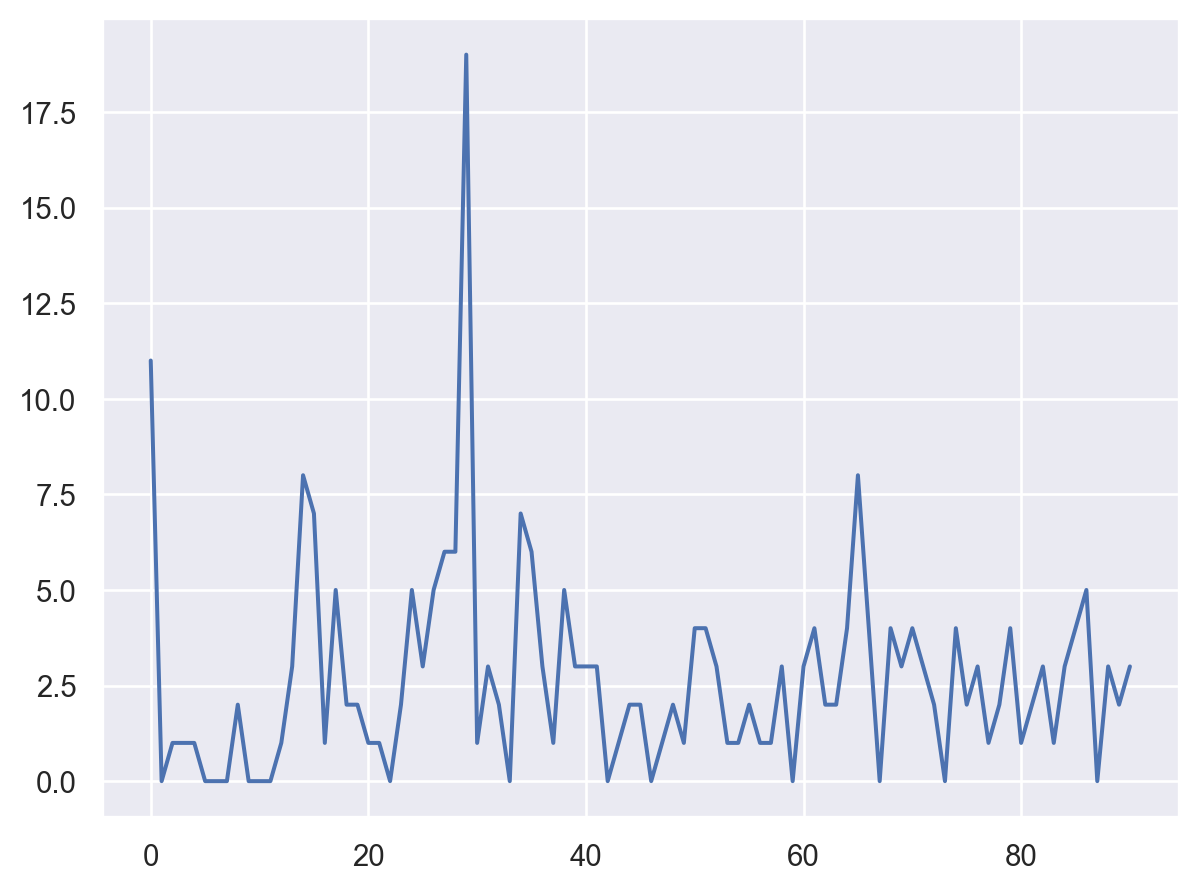

In [367]:
so.Plot( x=range(len(Scrores[0])), y=Scrores[1]).add(so.Line())

## Теперь посмотрим на график количества терминалов, которые имеют очков 0.8 и больше, т.е. в скором времени их нужно будет обслужить.
Снова всплеск, но теперь на день раньше. И снова идёт стабилизация работы алгоритма и наблюдается нисходящий тренд.


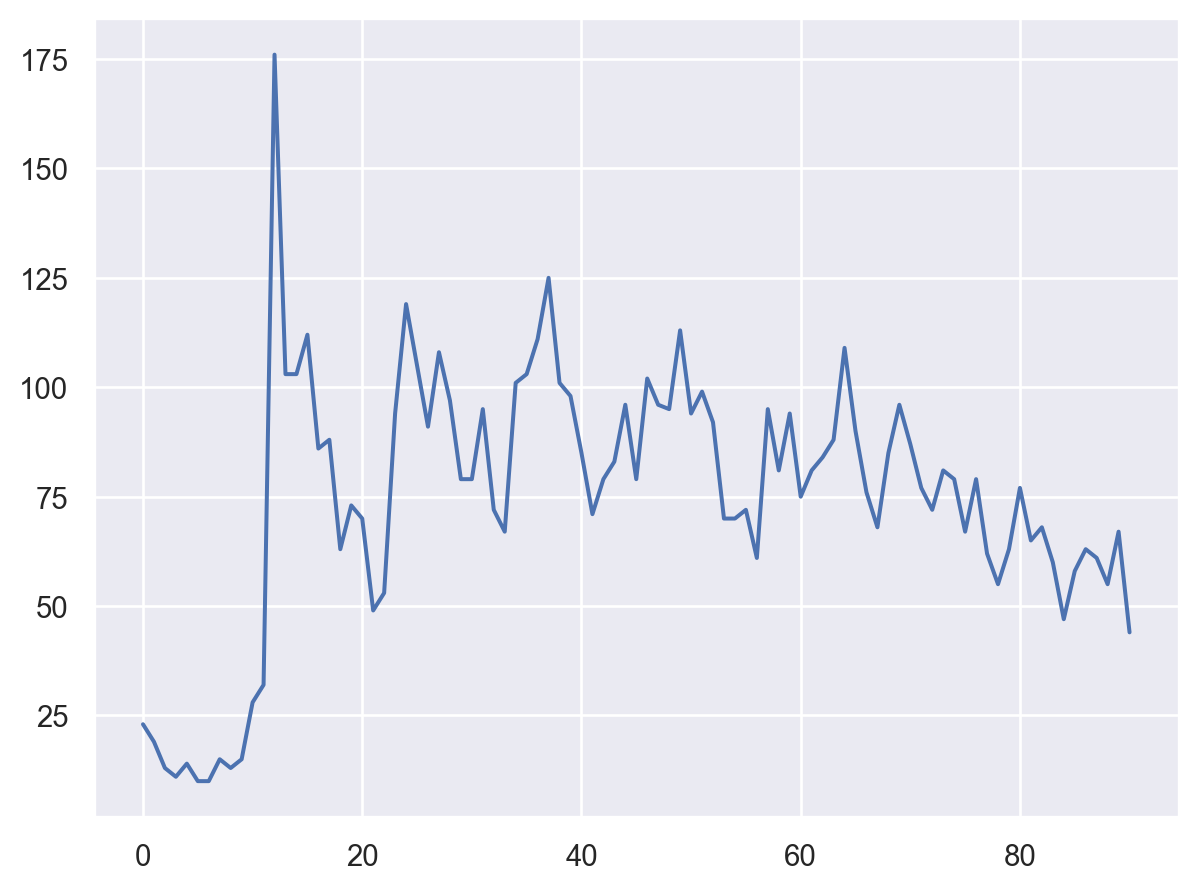

In [368]:
so.Plot( x=range(len(Scrores[0])), y=Scrores[0]).add(so.Line())

## Это график суммы потерь в день.  
График имеет колебания в несколько тысяч, это обусловленно колебаниями стоимости обслуживания в день,
т.к. количество посещённых банкоматов меняется. Можно заметить нисходящий тренд, вероятно,
минимум затрат ещё впереди.

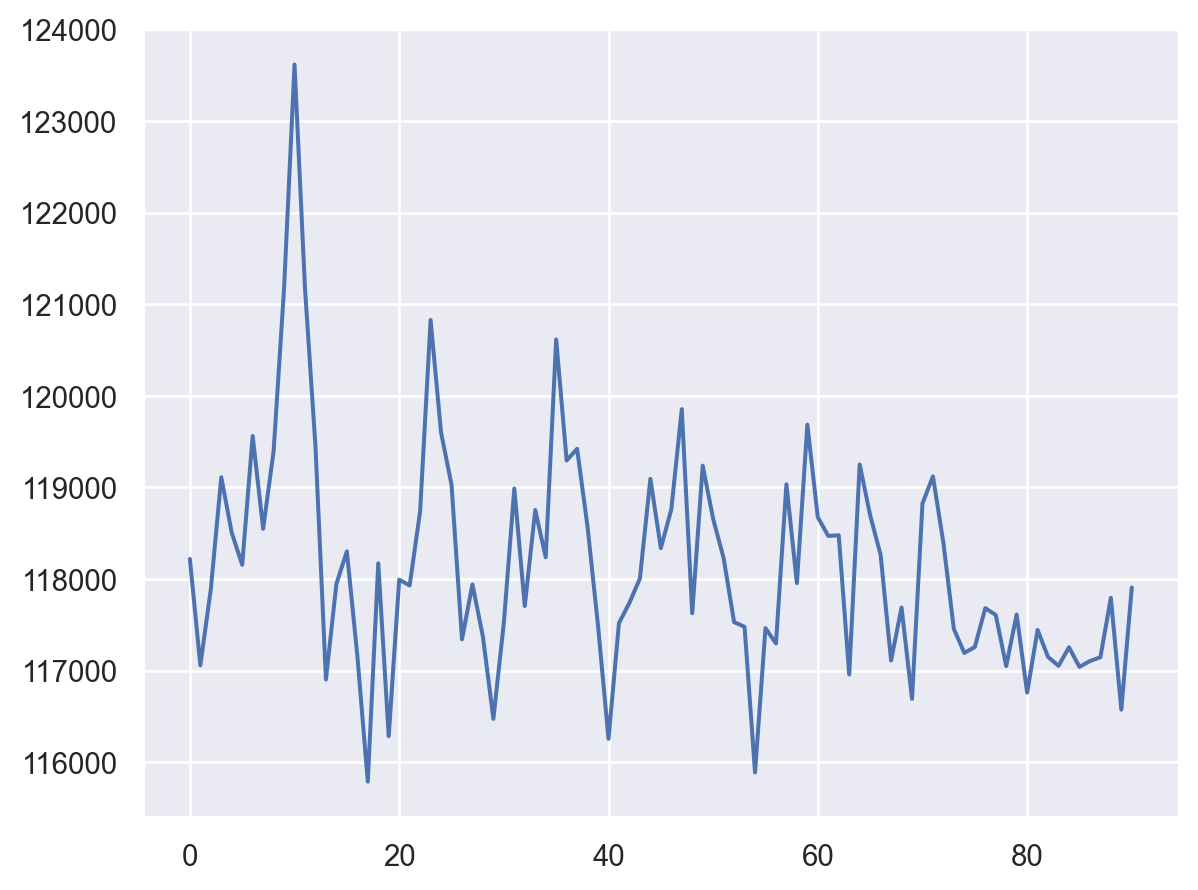

In [369]:

a = np.array(Scrores[2])
so.Plot( x=range(len(Scrores[0])), y=a[:, 0]).add(so.Line())

## Вывод общих потерь в тестовом месяце. 
1 - сумма, 2, 3, 4 - расходы на фондирование, обслуживание терминалов и содержание автопарка соответственно.

In [370]:
sum(a[61:])

array([3529007.16986301,  654757.36986301,  474249.8       ,
       2400000.        ])

## Выведем график расходов на фондирование. 
Судя по нисходящему тренду, количество денег в системе стабильно уменьшается,
что приводит к снижению общих расходов.

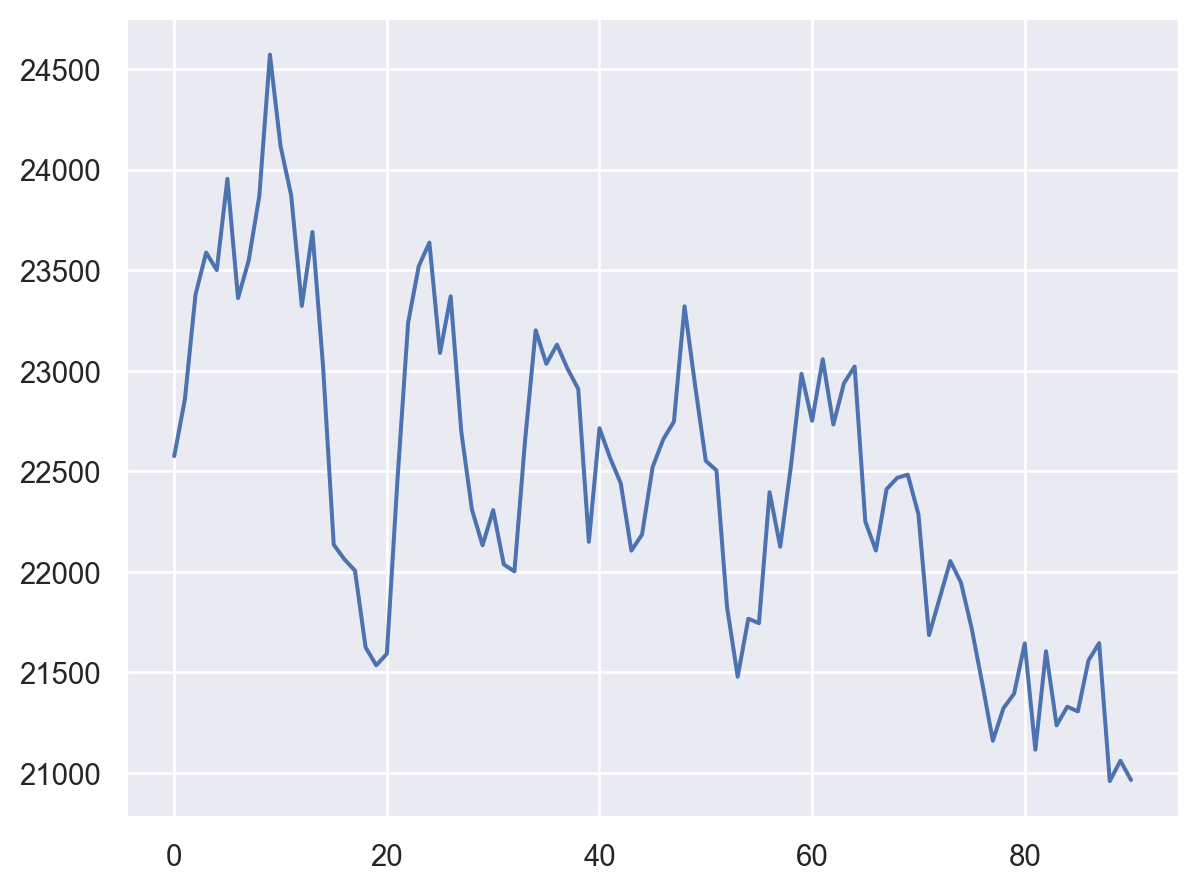

In [371]:
a = np.array(Scrores[2])
so.Plot( x=range(len(Scrores[0])), y=a[:, 1]).add(so.Line())

## График стоимости обслуживания банкоматов. 
Он относительно постоянен, большая амплитуда связана с разным количеством посещенных точек в день.

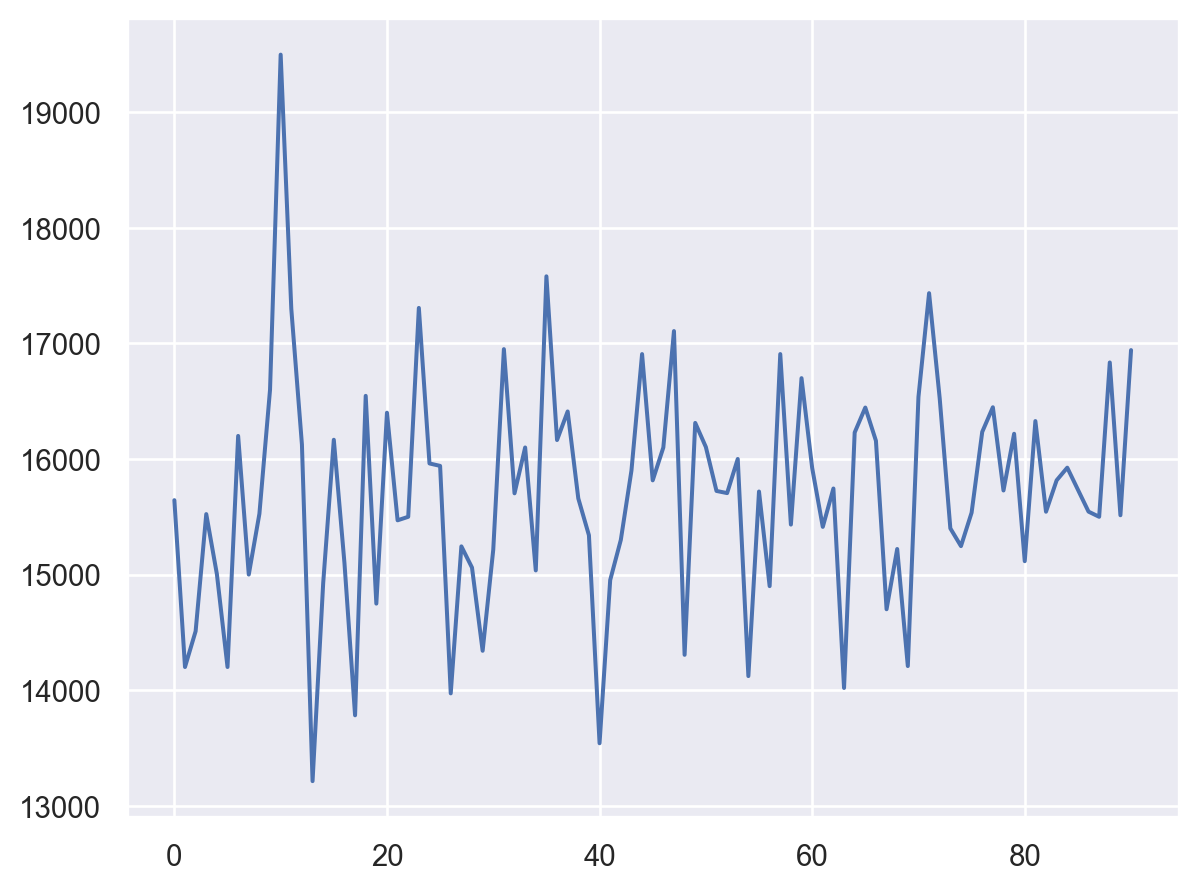

In [372]:
a = np.array(Scrores[2])
so.Plot( x=range(len(Scrores[0])), y=a[:, 2]).add(so.Line())

# Спасибо за внимание!